# Classification

# Author

Dawid Koceniak

# Abstract

The work presents an attempt to analyze and classify observations from a selected Machine Learning repository available [here](https://archive.ics.uci.edu/). The data processing process includes preliminary data analysis in the form of calculating descriptive statistics, standardizing variables and using classification models (linear regression, SVM, KNN, neural networks, random forests, decision trees, LDA, QDA) to assign observables to a specific category. Finally, we do a summary of our results in the form of a tabular statement of the various indicators that determine the accuracy of matching the categories of our observations.

# Subject of the study

The subject of the study is two varieties of rice grown in Turkey - Osmanick and Cammeo. Each of these species is distinguished by its own characteristics. 3810 images of rice grains of both species were taken, processed and traits were inferred. Eight morphological traits were obtained and stored in the repository.

# Purpose and scope of the study

With data available on two species of rice, we wanted to classify which belong to the $Cammeo$ species and which to the $Osmancik$ species.

# Key words

- clustering
- pipeline
- test and learning samples
- performance metrics

# Variables selected for analysis

`area` - the number of pixels on the borders of the rice grain  
`perimeter` - the perimeter, calculated from between the pixels around the borders of the rice grain  
`Major_Axis_Length` - the longest line that can be drawn on the rice grain, i.e. the distance of the major axis  
`Minor_Axis_Length` - the shortest line that can be drawn on the rice grain, i.e. the distance of the major axis  
`Eccentricity` - it measures how round the ellipse is, which has the same moments as the grain of rice  
`Convex_area` - it returns the number of pixels of the smallest convex shell of the area formed by the rice grain  
`Extent` - Returns the ratio of the area formed by the rice grain to the envelope  
`Class` - Cammeo and Osmancik.

# Preliminary data analysis

##### Library import

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA


##### Loading data

In [75]:
df = pd.read_excel('rice.xlsx').set_index('Class')

##### Handling data gaps

In [76]:
np.sum(np.isnan(df), axis=0)

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
dtype: int64

We find that there are no empty values

##### Visualization of variables, along with their estimated densities

In this step, we will visualize all the variables, wanting to obtain density histograms (so the vertical axis represents frequencies, instead of the number of values of the variable that occur). In addition, for a deeper understanding, we used the [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) method from the SeaBorn package to plot the estimated density curve. You can read more about the implemented method [here](https://en.wikipedia.org/wiki/Kernel_density_estimation).

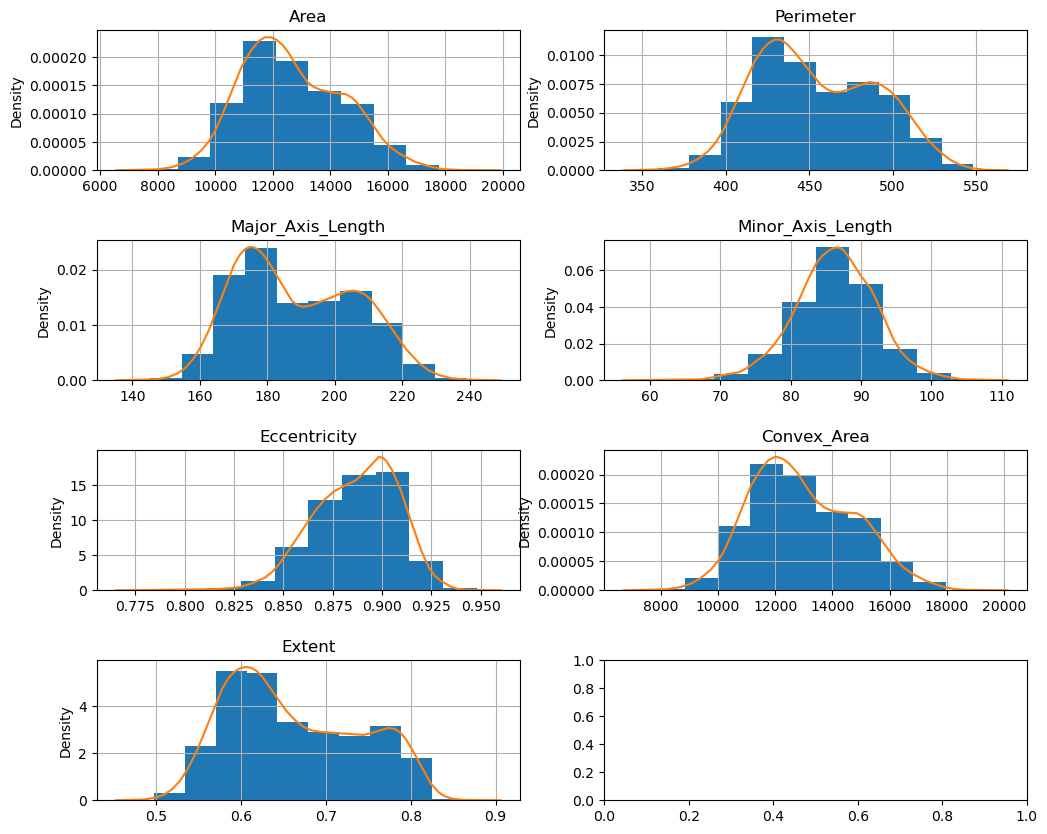

In [77]:
plt.style.use('fast')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
for ax, col in zip(axs.flat, df.columns):
    ax.hist(df[col], bins=10, density=True)
    sns.kdeplot(df[col], ax=ax)
    ax.grid(True)
    ax.set_title(col)
    ax.set_xlabel('')

##### Descriptive statistics

In this section we will count and interpret the descriptive statistics of our dataset. We have added calculated [skewness](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html#scipy.stats.skew) and [kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) to the basic statistics calculated by the Pandas package.

In [78]:
skewnesses = skew(df, axis=0)
kurtosises = kurtosis(df, axis=0)
stats = pd.concat([df.describe(), pd.DataFrame({'skewness':skewnesses, 'kurtosis':kurtosises}, index=df.columns).T]).T
stats['coef_of_var'] = stats['std'] / stats['mean']
stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,coef_of_var
Area,3810.0,12667.727559,1732.367706,7551.000000,11370.500000,12421.500000,13950.000000,18913.000000,0.325030,-0.432091,0.136754
Perimeter,3810.0,454.239180,35.597081,359.100006,426.144752,448.852493,483.683746,548.445984,0.221275,-0.840715,0.078366
Major_Axis_Length,3810.0,188.776222,17.448679,145.264465,174.353855,185.810059,203.550438,239.010498,0.260140,-0.952128,0.092430
Minor_Axis_Length,3810.0,86.313750,5.729817,59.532406,82.731695,86.434647,90.143677,107.542450,-0.134844,0.559801,0.066384
Eccentricity,3810.0,0.886871,0.020818,0.777233,0.872402,0.889050,0.902588,0.948007,-0.449072,0.069405,0.023473
Convex_Area,3810.0,12952.496850,1776.972042,7723.000000,11626.250000,12706.500000,14284.000000,19099.000000,0.319656,-0.466788,0.137191
Extent,3810.0,0.661934,0.077239,0.497413,0.598862,0.645361,0.726562,0.861050,0.343684,-1.030324,0.116687


# Classification models

## Preparing data to perform classification

##### Loading data

In [79]:
df = pd.read_excel('rice.xlsx', header=None)
X = df.loc[1:, :6].values
y = df.loc[1:, 7].values

Using the LabelEncoder object, we convert class labels to integers

In [80]:
le = LabelEncoder()
y = le.fit_transform(y)
print("Class labels: ", le.classes_)

Class labels:  ['Cammeo' 'Osmancik']


In [81]:
le.transform(['Cammeo', 'Osmancik'])

array([0, 1])

##### Divide the dataset into a training sample (80% of the data) and a test sample (20% of the data).

In [82]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, 
                     stratify = y,
                     random_state = 0)

In [83]:
print('Labels counts in y: ', np.bincount(y))
print('Labels counts in y_train: ', np.bincount(y_train))
print('Labels counts in y_test: ', np.bincount(y_test))

Labels counts in y:  [1630 2180]
Labels counts in y_train:  [1304 1744]
Labels counts in y_test:  [326 436]


##### Standardization of variables

In [84]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

##### Create plot_decision_regions() function

Function implementation for visualizing decision boundaries of two-dimensional data

In [85]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<', '>', 'D', 'P', 'X', '*')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orange', 'purple', 'pink', 'yellow', 'black')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # Plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')


The function draws a decision area based on the training data and classifier, and displays class examples.

We define the number of colors and markers and create a color map from the color list using `ListedColormap`.

We create a grid of `xx1` and `xx2` points based on the minimum and maximum feature values, and then predict classes for each point on the grid using the `classifier.predict` classifier model. The resulting contour plot shows the decision area, where different colors correspond to different classes, and training points are also displayed on the plot, representing different classes.

In addition, using different markers `markers` and colors `colors`, the function marks points for different classes on the graph to visually distinguish between classes.

The `plot_decision_regions` will be used by us when we select models later in the project with the best possible fit to the data.

## Logistic regression

Initialization of the PCA tranformer and logistic regression estimator

In [86]:
pca = PCA(n_components = 2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')

Dimension reduction

In [87]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Fitting a logistic regression model to a reduced data set

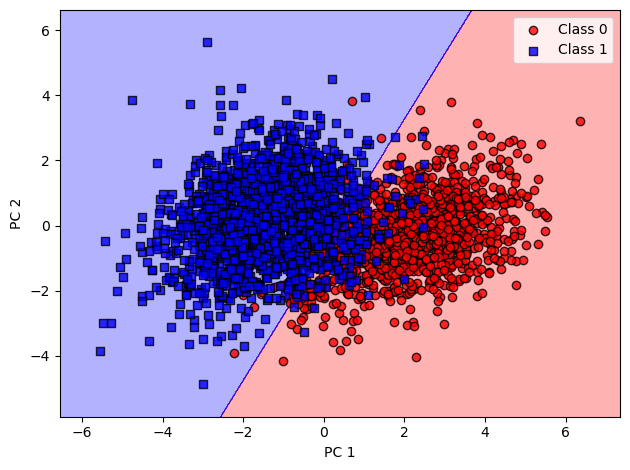

In [88]:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

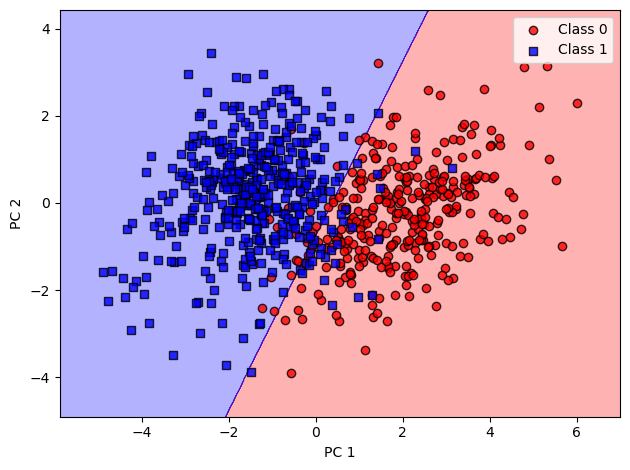

In [89]:
plot_decision_regions(X_test_pca, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### Analysis of performance evaluation indicators for logistic regression model

#### Combining transformers and estimators in a pipeline
We normalize the columns in the dataset using `StandardScaler`, compress the data into a two-dimensional subspace using `PCA`. and then pass it to the logistic regression classifier `LogisticRegression`, using the `make_pipeline` function.

In [90]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc_lr = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc_lr: .3f}')

Test accuracy:  0.923


The `make_pipeline` function takes an arbitrary number of scikit-learn transformers, followed by a scikit-learn estimator that implements the `fit` and `predict` methods.

In the above notation, we have provided two scikit-learn transformers - `StandardScaler` and `PCA` - and the `LogisticRegression` estimator as input to the `make_pipeline` function, which constructs a scikit-learn `Pipeline` object from these objects.

Finally, we return a prediction based on the transformed data.

#### Confusion matrix

In [91]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[300  26]
 [ 33 403]]


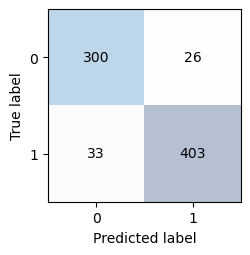

In [92]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [93]:
scores_lr = cross_val_score(estimator = pipe_lr,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_lr}')
print(f'CV accuracy scores: {np.mean(scores_lr):.3f}'
      f' +/- {np.std(scores_lr):.3f}')

CV accuracy scores: [0.92786885 0.93770492 0.90819672 0.91803279 0.9147541  0.94754098
 0.92131148 0.9147541  0.92763158 0.91447368]
CV accuracy scores: 0.923 +/- 0.011


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

Both prediction error (ERR) and accuracy (ACC) provide general information about how many examples were misclassified. Error can be understood as the sum of all false predictions divided by the number by the total number of predictions, and accuracy is calculated as the sum of correct predictions divided by the total number of predictions. divided by the total number of predictions, respectively:
$$ ERR = \frac{FP + FN}{FP + FN + TP + TN}$$

The prediction accuracy can then be calculated directly from the error:
$$ ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR $$

**True Positive Rate** and **False Positive Rate** are performance metrics that are particularly useful for problems with unbalanced classes:
$$ FPR = \frac{FP}{N} = \frac{FP}{FP+TN}$$
$$ TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$$

The performance indicators **precision (PRE)** and **recall (REC)** are related to these indicators TP and TN, and in fact REC is synonymous with TPR:

$$REC = TPR = \frac{TP}{P} = \frac{TP}{FN + TP} $$

In other words, recall quantifies how many relevant (positive) records were captured as such (true positives). Precision determines how many records predicted to be relevant (the sum of true positives and false positives) are actually relevant (true positives):

$$ PRE = \frac{TP}{TP + FP}$$

To balance the advantages and disadvantages of PRE and REC optimization, the harmonic average of PRE and REC, the so-called F1 score, is used:

$$ F1 = 2 \frac{PRE \times REC}{PRE + REC}$$

The summary measure of the confusion matrix is the MCC. The MCC is calculated as follows:
$$ MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TP + FP)(TN + FN)}}$$


Unlike PRE, REC and the F1 score, MCC ranges from -1 to 1 and takes into account all elements of the confusion matrix - for example, the F1 score does not include TN.

Although MCC values are more difficult to interpret than the F1 score, it is considered a better indicator, as described in the following article: The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation by D. Chicco and G. Jurman, BMC Genomics. pp. 281-305, 2012, https://bmcgenomics.biomedcentral.com/articles/10.1186/s1 864-019-6413-7. 

All of these scoring metrics are implemented in scikit-learn and can be imported from the sklearn module. metrics, as shown in the excerpt below:

In [94]:
pre_val_lr = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_lr}')

rec_val_lr = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_lr}')

f1_val_lr = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_lr}')

mcc_val_lr = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_lr:.3f}')

Precision: 0.9393939393939394
Recall: 0.9243119266055045
F1: 0.9317919075144507
MCC: 0.842


#### ROC curve

Receiver operating characteristic (ROC) curves are useful tools for selecting models for classification based on their performance with respect to FPR and TPR, which are calculated by shifting the decision threshold of the classifier.

The diagonal of the ROC graph can be interpreted as random guessing, and classification models that fall below the diagonal are considered worse than random guessing. 

An ideal classifier would be in the upper left corner of the graph with a TPR of 1 and an FPR of 0. Based on the ROC curve, we can then calculate the so-called ROC area under the curve (ROC AUC) to characterize the performance of the classification model.

Performing the following code example, we will plot the ROC curve of a classifier that uses only two features from the dataset to predict whether the rice is of the Cammeo or Osmancik class. Although we are going to use the same logistic regression pipeline we defined earlier, this time we are using only two features. This is to make the classification task more difficult for the classifier, by withholding useful information contained in the other features, so that the resulting ROC curve becomes more visually interesting. For similar reasons, we also reduce the number of splits in the StratifiedKFold validator to three. 

The code looks as follows:

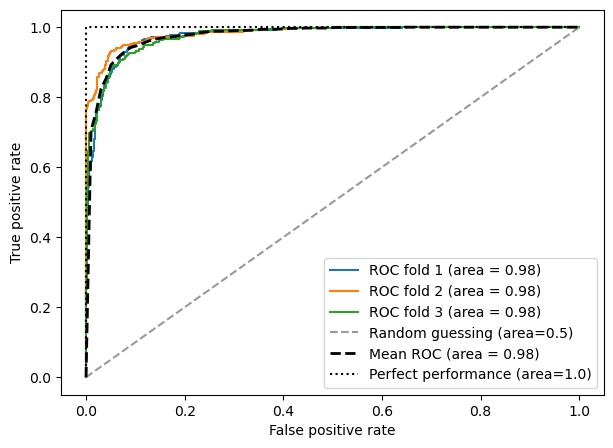

In [95]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components = 2),
    LogisticRegression(penalty = 'l2', random_state = 1,
                       solver = 'lbfgs', C = 100.0)
)
X_train2 = X_train[:, [1, 2]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
     probas = pipe_lr.fit(
          X_train2[train],
          y_train[train]).predict_proba(X_train2[test])
     fpr, tpr, thresholds = roc_curve(y_train[test],
                                      probas[:, 1],
                                      pos_label=1)
     mean_tpr += interp(mean_fpr, fpr, tpr)
     mean_tpr[0] = 0.0
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr,
              tpr,
              label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

In the code, we used the familiar `StratifiedKFold` class from `scikit-learn` and calculated the `ROC` performance of the `LogisticRegression` classifier in our `pipe_lr` pipeline using the `roc_curve` function from the `sklearn.metrics` module separately for each iteration. In addition, we interpolated the average `ROC` curve from the three kinks using the `interp` function that we imported from `NumPy` and calculated the area under the curve using the `AUC` function.The resulting `ROC` curve indicates that there is a high convergence between the different folds, and the average ROC AUC value (0.98) falls between an ideal result (1.0) and a random guess (0.5).

Note that if you are only interested in the `ROC AUC` score, you can also directly import the `roc_auc_score` function from the `sklearn.metrics` submodule, which can be used similarly to other scoring functions (for example, `precision_score`).Reporting the performance of a classifier as `ROC AUC` can provide further information on the performance of the classifier with respect to unbalanced samples.

However, while the accuracy score can be interpreted as a single cutoff point on the `ROC` curve, A. P. Bradley has shown that the `ROC AUC` and accuracy metrics mostly agree with each other: The Use of the Area Under the ROC Curve in the Evaluation of Machine Learning Algorithms by A. P. Bradley, Pattern Recognition, 30(7): 1145-1159, 1997, https://reader.elsevier.com/reader/sd/pii/S0031320396001422

#### Diagnosing deviation and variance problems using learning curves

Tutatj we present the performance of a learning curve and a validation curve for diagnosis. We will look at whether the algorithm has a problem with over-fitting (high variance) or under-fitting (high deviation).If the model is too complex for a given set of training data - the model then tends to over-fit the training data and does not generalize well to unseen data. 

It can often be helpful to collect more training examples to reduce the degree of over-fitting.However, in practice, collecting more data can often be very expensive or simply not feasible. 

By plotting the accuracy of the training and validation model as a function of the size of the training dataset, we can easily detect whether the model suffers from high variance or high bias, and whether collecting more data can help solve this problem.


Let's see how we can use the learning curve function from scikit-learn to evaluate the model:

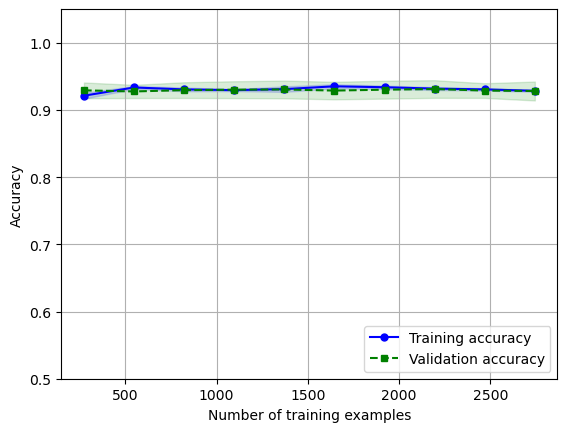

In [96]:
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',
                                           max_iter=10000))
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(
                       0.1, 1.0, 10),
                       cv=10,
                       n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.05])
plt.show()


We passed `max_iter = 10000` as an additional argument when creating an instance of the `LogisticRegression` object (which uses 1000 iterations by default) to avoid convergence problems for smaller dataset sizes or extreme values of regularization parameters.

Using the `train_sizes` parameter in the `learning_curve` function, we can control the absolute or relative number of training examples that are used to generate learning curves.

Here we set `train_sizes = np.linspace(0.1,1.0,10)` to use 10 evenly spaced relative intervals for the size of the training dataset. 

By default, the `learning_curve` function uses k-fold cross-validation to calculate the classifier's cross-validation accuracy, and we set $k = 10$ using the `cv` parameter for 10-fold stratified cross-validation.

We then simply calculate the average accuracy based on the returned cross-validated training and test results for different sizes of the training dataset, which we plotted using the `Matplotlib` plot function. 

In addition, we added the standard deviation of the mean accuracy to the graph using the `fill_between` function to indicate the variance of the estimate.

As we can see in the previous learning curve plot, our model performs very well on both the training and validation datasets.

#### Solve over-fitting and under-fitting problems with validation curves

Validation curves are a useful tool for improving model performance by solving problems such as over- or under-fitting.

Validation curves are related to learning curves, but instead of plotting as a function of sample size, we change the values of model parameters, such as the inverse regularization parameter, C, in logistic regression.

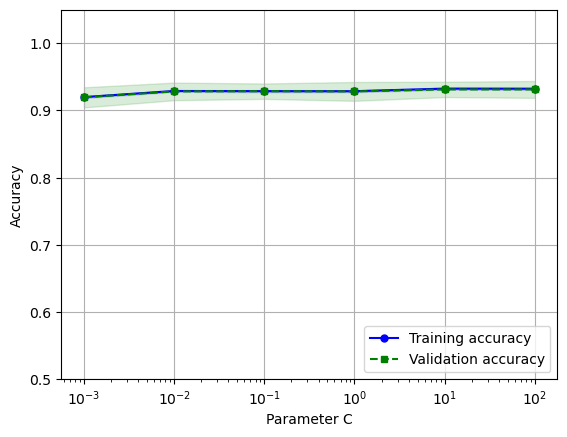

In [97]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr,
    X = X_train,
    y = y_train,
    param_name = 'logisticregression__C',
    param_range = param_range,
    cv = 10)
train_mean = np.mean(train_scores , axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(param_range, train_mean, color = 'blue',
         marker = 'o', markersize = 5, 
         label = 'Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha = 0.15,
                 color = 'blue')
plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'Validation accuracy')
plt.fill_between(param_range,
          test_mean + test_std,
          test_mean - test_std,
          alpha = 0.15, color = 'green')
plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.show()

Like the `learning_curve` function, the `validation_curve` function implicitly uses layered k-fold cross-validation to estimate classifier performance.

Inside the `validation_curve` function, we specified the parameter we wanted to evaluate. In this case, it is `C`, the inverse regularization parameter of the `LogisticRegression` classifier, which we stored as `logisticregression__C`.

To access the `LogisticRegression` object inside the scikit-learn pipeline for a specific range of values, which we set using the `param_range` parameter.

As in the learning curve example in the previous section, we plotted the average training and cross-validation accuracy and their corresponding standard deviations.

We see that for any C, the model fits the data well.

#### Tuning machine learning models through grid search (Grid Search)

We will now use a technique for optimizing hyperparameters (learning algorithm parameters subjected to separate optimization) called grid search (**Grid Search**), which can further help improve model performance by finding their optimal combination of values.

The operation of Grid Search is as follows: it is a brute-force exhaustive search paradigm, in which we specify a list of values for various hyperparameters, and the computer evaluates the model's performance for each combination to get the optimal combination of values from that set.

In [98]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, random_state=1))

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Zakres parametru regularyzacji C
    'logisticregression__solver': ['liblinear', 'lbfgs', 'sag', 'saga']  # Wybór solvera
}

gs_lr = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs_lr = gs_lr.fit(X_train, y_train)

print(gs_lr.best_score_)
print(gs_lr.best_params_)


0.9314279551337359
{'logisticregression__C': 10.0, 'logisticregression__solver': 'sag'}


We initialized the `GridSearchCV` object from the `sklearn.model_selection` module to train and tune the `LogisticRegression` pipeline.

We set the `param_grid` parameter of the `GridSearchCV` object to a list of dictionaries to specify the parameters we want to tune. 

`GridSearchCV` uses k-fold cross-validation to compare trained models with different hyperparameter settings.
By setting `cv = 10`, it will perform a 10-fold cross-validation and calculate the average accuracy (via `scoring='accuracy'`) in these 10-folds to evaluate the model's performance. 

We have set `n_jobs=-1` so that `GridSearchCV` can use all of our processing cores to speed up the grid search by matching models to different splits in parallel.


After using the training data to perform the grid search, we obtained the result of the best performing model via the `best_score_` attribute and looked at its parameters, which can be accessed via the `best_params_` attribute. 

In this particular case, the `sag` solver with `logisticregression__C = 10` obtained the best accuracy of k-chroned cross-validation at $93.

Na koniec wykorzystujemy niezależny zestaw danych testowych do oszacowania wydajności najlepiej wybranego modelu, który jest dostępny za pośrednictwem atrybutu `best_estimator_` obiektu `GridSearchCV`

In [99]:
clf_lr = gs_lr.best_estimator_
clf_lr.fit(X_train, y_train)
print(f'Test accuracy: {clf_lr.score(X_test, y_test):.3f}')

Test accuracy: 0.924


Moreover, we can use a different scoring metric than accuracy in GridSearchCV through the scoring parameter.

In [100]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_lr,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9210531934579306
{'logisticregression__C': 100.0, 'logisticregression__solver': 'sag'}


#### Choosing an algorithm with nested cross-validation

Using k-fold cross-validation in combination with grid search or randomized search is a useful approach to tune the performance of a machine learning model by changing its hyperparameter values.

However, if you want to choose a different machine learning algorithm, nested cross-validation is the recommended approach.

In an interesting study on bias in error estimation, Sudhir Varma and Richard Simon concluded that the true estimation error is almost unbiased with respect to the test data set when nested cross-validation is used (Bias in Error Estimation When Using Cross-Validation for Model Selection by S. Varma and R. Simon, BMC Bioinformatics, 7(1): 91, 2006, https://bmcbioinformatics.biomedcentral.com/articl es/10.1186/1471-2105-7-91).


In nested cross-validation, we have an outer loop of k-fold cross-validation to split the data into training and test splits, and an inner loop is used to select the model using k-fold cross-validation on the training split.
After model selection, the test split is then used to evaluate model performance.


In `scikit-learn`, we can perform nested cross-validation with grid search as follows:

In [101]:
nested_gs_lr = GridSearchCV(estimator = pipe_lr,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_lr = cross_val_score(nested_gs_lr, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_lr):.3f}'
      f' +/- {np.std(nested_scores_lr):.3f}')

CV accuracy: 0.930 +/- 0.010


The returned average cross-validation accuracy gives us a good estimate of what to expect if we tune the model's hyperparameters and use it on unseen data.

### Testing hyperparameter configurations using randomized search (Randomized Search).

The `scikit-learn` package implements the `RandomizedSearchCV` class, which is analogous to `GridSearchCV`. The main difference is that we can specify distributions as part of our parameter grid and specify the total number of hyperparameter configurations to evaluate.

For example, consider the range of hyperparameters we used for several hyperparameters when tuning Logistic Regression in the example of the grid search mentioned earlier.

In [102]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, random_state=1))

param_dist = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Adjustment parameter range C
    'logisticregression__solver': ['liblinear', 'lbfgs', 'sag', 'saga']  # solver selection
}

rs_lr = RandomizedSearchCV(estimator=pipe_lr,
                        param_distributions=param_dist,
                        scoring='accuracy',
                        n_iter=20,
                        cv=10,
                        refit=True,
                        random_state=1,
                        n_jobs=-1)
rs_lr.fit(X_train, y_train)

print(rs_lr.best_score_)
print(rs_lr.best_params_)

0.9314279551337359
{'logisticregression__solver': 'sag', 'logisticregression__C': 10.0}


## SVM

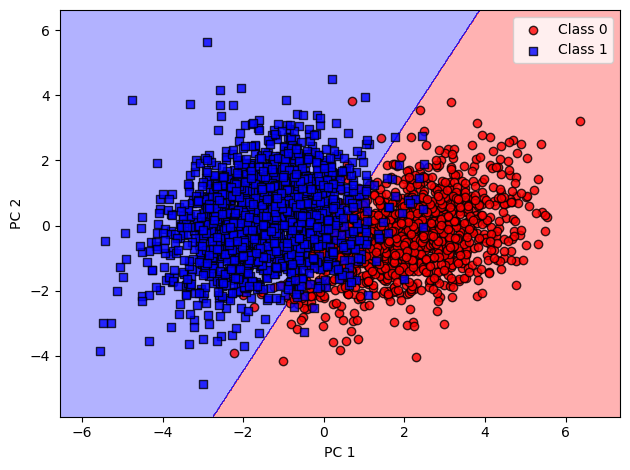

In [103]:
svm = SVC(kernel = 'linear', C = 10.0, random_state = 1)

svm.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=svm)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

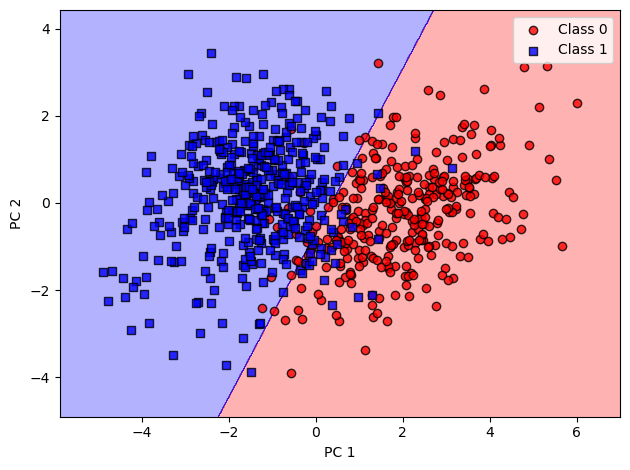

In [104]:
plot_decision_regions(X_test_pca, y_test, classifier=svm)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analysis of performance evaluation indicators for the SVM model

#### Combining transformers and estimators in a pipeline

In [105]:
pipe_svc = make_pipeline(StandardScaler(),
                        SVC(kernel = 'linear',
                            C = 10.0,
                            random_state=1))
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
test_acc_svc = pipe_svc.score(X_test, y_test)
print(f'Test accuracy: {test_acc_svc: .3f}')

Test accuracy:  0.920


#### Confusion matrix

In [106]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[297  29]
 [ 32 404]]


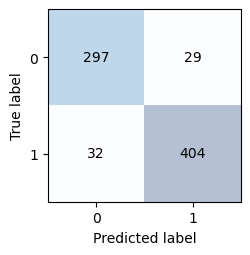

In [107]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [108]:
scores_svc = cross_val_score(estimator = pipe_svc,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_svc}')
print(f'CV accuracy scores: {np.mean(scores_svc):.3f}'
      f' +/- {np.std(scores_svc):.3f}')

CV accuracy scores: [0.93442623 0.93770492 0.91803279 0.93770492 0.93442623 0.96065574
 0.93442623 0.9147541  0.91776316 0.92434211]
CV accuracy scores: 0.931 +/- 0.013


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

In [109]:
pre_val_svc = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_svc}')

rec_val_svc = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_svc}')

f1_val_svc = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_svc}')

mcc_val_svc = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_svc:.3f}')

Precision: 0.9330254041570438
Recall: 0.926605504587156
F1: 0.9298043728423475
MCC: 0.837


#### ROC curve

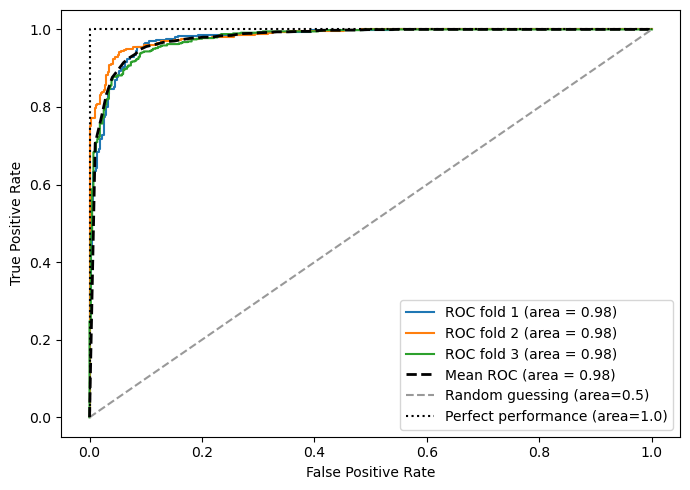

In [110]:
pipe_svc = make_pipeline(StandardScaler(), SVC(kernel = 'linear', C = 10.0, probability=True, random_state=1))

# Breakdown of data for cross-validation
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Initialising the graph
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# For each cross-validation split
for i, (train, test) in enumerate(cv):
    # Fitting the model to the training data
    probas = pipe_svc.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Calculation of True Positive Rate (TPR) and False Positive Rate (FPR) factors
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolation of results to the mean ROC curve
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Calculation of the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Display the ROC curve for each division
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Calculation of the average True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Calculation of mean area under the ROC curve (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Displaying the average ROC curve
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Displaying reference lines
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Axis and legend settings
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### Diagnosing bias and variance problems using learning curves

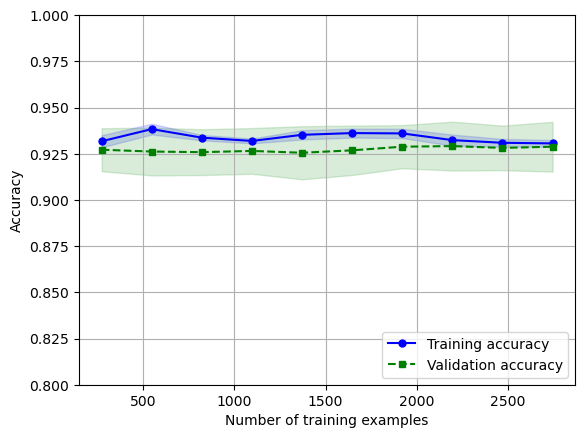

In [111]:
# Creation of a pipeline using StandardScaler and SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=1))

# Generate a learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svc,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

# Calculation of means and standard deviations of accuracy for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()


### Dealing with the problem of over- and under-fitting using validation curves

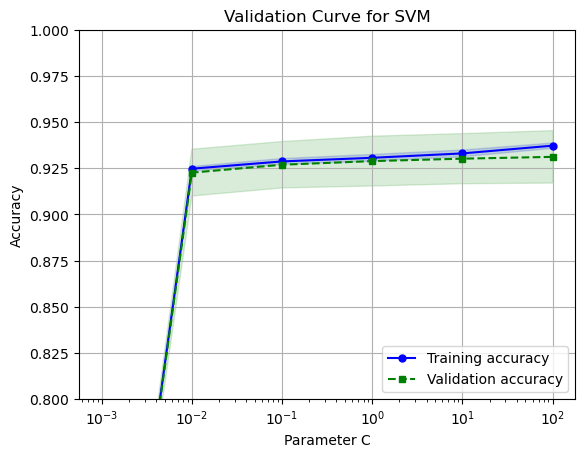

In [112]:
pipe_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=1))

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Generate validation curve for the parameter C in SVC
train_scores, test_scores = validation_curve(estimator=pipe_svc,
                                             X=X_train,
                                             y=y_train,
                                             param_name='svc__C',
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.title('Validation Curve for SVM')
plt.show()


#### Tuning machine learning models through Grid Search

In [113]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))
param_range = [0.001, 0.01, 0.1,
               1.0, 10.0, 100.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel':['rbf']}]
gs_svc = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  refit = True,
                  n_jobs = -1)
gs_svc = gs_svc.fit(X_train, y_train)
print(gs_svc.best_score_)
print(gs_svc.best_params_)

0.9314236410698877
{'svc__C': 10.0, 'svc__kernel': 'linear'}


In [114]:
clf_svc = gs_svc.best_estimator_
clf_svc.fit(X_train, y_train)
print(f'Test accuracy: {clf_svc.score(X_test, y_test):.3f}')

Test accuracy: 0.920


In [115]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9204763085497031
{'svc__C': 10.0, 'svc__kernel': 'linear'}


#### Nested cross-validation using GridSearchCV

In [116]:
nested_gs_svc = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_svc = cross_val_score(nested_gs_svc, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_svc):.3f}'
      f' +/- {np.std(nested_scores_svc):.3f}')

CV accuracy: 0.930 +/- 0.010


#### Examination of hyperparameter configurations using Randomized Search

In [117]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))
param_dist = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel':['rbf']}]

rs_svc = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs_svc = rs_svc.fit(X_train, y_train)
print(rs_svc.best_score_)
print(rs_svc.best_params_)

0.9314236410698877
{'svc__kernel': 'linear', 'svc__C': 10.0}


## Decimal Decision Tree

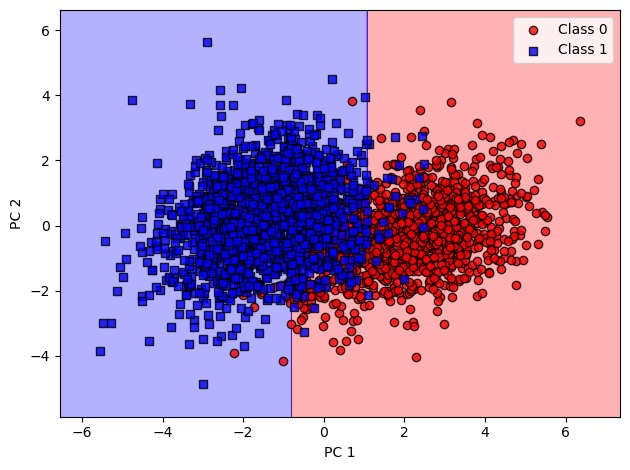

In [118]:
# Creating a decision tree classifier object
tree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1)

# Fitting the model to PCA data
tree.fit(X_train_pca, y_train)

# Visualizing the results on the training set after PCA
plot_decision_regions(X_train_pca, y_train, classifier=tree)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


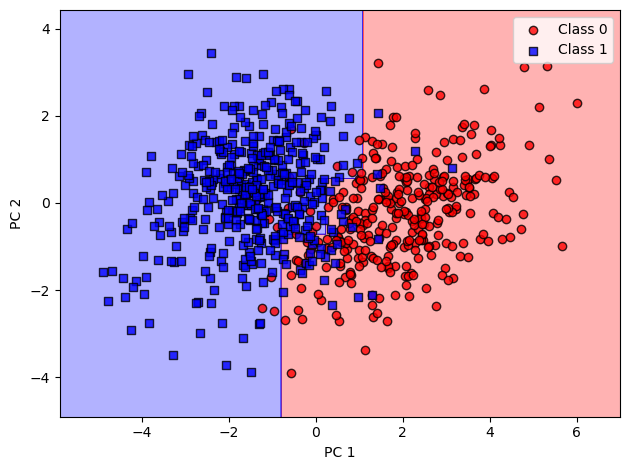

In [119]:
# Visualizing the results on the test set after PCA
plot_decision_regions(X_test_pca, y_test, classifier=tree)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Analysis of performance evaluation indicators for the Decision Tree model

#### Combining transformers and estimators in a pipeline

In [120]:
# Create a pipeline containing StandardScaler and DecisionTreeClassifier
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# Train the model on the training data
pipe_dt.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = pipe_dt.predict(X_test)

# Calculate the model accuracy on the test data
test_acc_dt = pipe_dt.score(X_test, y_test)
print(f'Test accuracy (DecisionTreeClassifier): {test_acc_dt:.3f}')


Test accuracy (DecisionTreeClassifier): 0.888


#### Confusion matrix

In [121]:
pipe_dt.fit(X_train, y_train)
y_pred = pipe_dt.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[288  38]
 [ 47 389]]


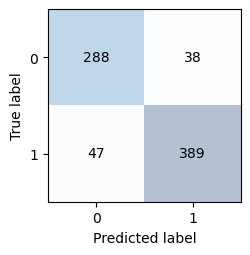

In [122]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [123]:
scores_dt = cross_val_score(estimator = pipe_dt,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_dt}')
print(f'CV accuracy scores: {np.mean(scores_dt):.3f}'
      f' +/- {np.std(scores_dt):.3f}')

CV accuracy scores: [0.89836066 0.90163934 0.8852459  0.90491803 0.89836066 0.89180328
 0.89508197 0.88196721 0.875      0.85526316]
CV accuracy scores: 0.889 +/- 0.014


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

In [124]:
pre_val_dt = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_dt}')

rec_val_dt = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_dt}')

f1_val_dt = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_dt}')

mcc_val_dt = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_dt:.3f}')

Precision: 0.9110070257611241
Recall: 0.8922018348623854
F1: 0.9015063731170336
MCC: 0.773


#### ROC curve

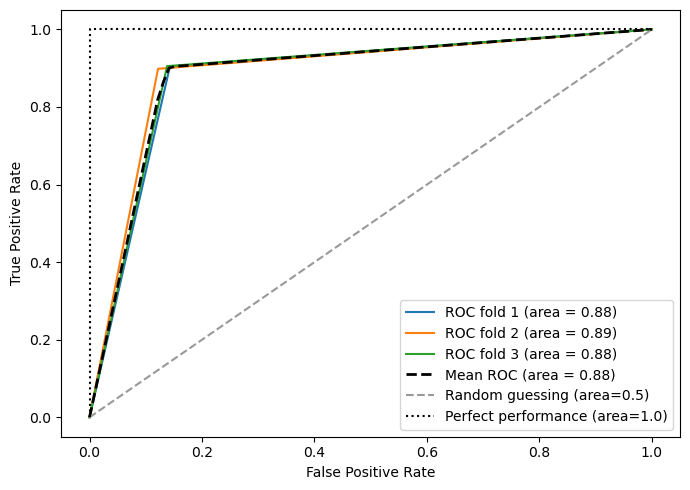

In [125]:
# Data split for cross-validation
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Initialize the plot
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# For each cross-validation split
for i, (train, test) in enumerate(cv):
    # Fit the model to the training data
    probas = pipe_dt.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolate the results onto a mean ROC curve
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Display the ROC curve for each split
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Calculate the mean True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean area under the ROC curve (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Display the mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Display reference lines
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Set axis and legend
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### Diagnosing bias and variance problems using learning curves

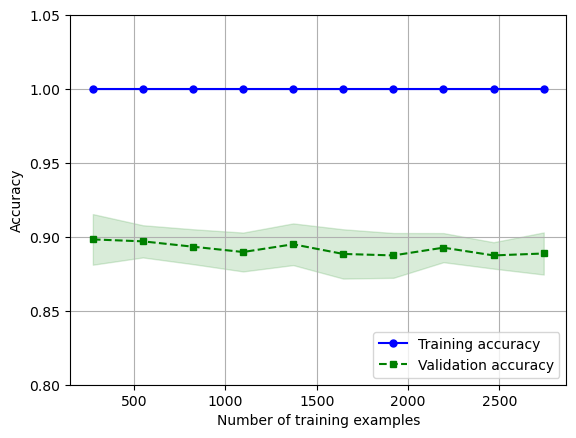

In [126]:
# Generating the learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_dt,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

# Calculating the means and standard deviations of accuracy for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.show()


### Dealing with the problem of over- and under-fitting using validation curves

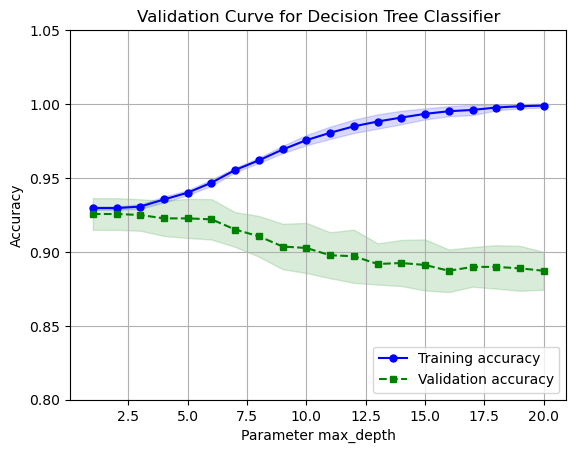

In [127]:
pipe_dt = DecisionTreeClassifier(random_state = 1)

# Define the parameter range for max_depth to be tested
param_range = np.arange(1, 21)

# Generate the validation curve for the max_depth parameter in DecisionTreeClassifier
train_scores, test_scores = validation_curve(estimator=pipe_dt,
                                             X=X_train,
                                             y=y_train,
                                             param_name='max_depth',
                                             param_range=param_range,
                                             cv=10)


# Calculate the mean accuracies for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.05])
plt.title('Validation Curve for Decision Tree Classifier')
plt.show()


#### Tuning machine learning models through Grid Search

In [132]:
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state = 1))

# Definition of parameter grid to search
param_grid = {
    'decisiontreeclassifier__max_depth': [None, 1, 2, 3, 4, 5], # Example values for the max_depth parameter
    'decisiontreeclassifier__min_samples_split': [2, 5, 10], # Example values for the min_samples_split parameter
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4, 5], # Example values for the min_samples_leaf parameter
    'decisiontreeclassifier__criterion': ['gini', 'entropy'] # Criterion selection
}

# Creating a GridSearchCV object
gs_dt = GridSearchCV(estimator=pipe_dt,
                  param_grid=param_grid,
                  scoring='accuracy',  # Choice of evaluation metric
                  cv=5,  # Number of cross-validation splits
                  n_jobs=-1)  # Utilize all CPU cores

# Running the grid search process
gs_dt.fit(X_train, y_train)

# Displaying the best parameters and results
print(gs_dt.best_score_)
print(gs_dt.best_params_)


0.9245368650569329
{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}


In [133]:
clf_dt = gs_dt.best_estimator_
clf_dt.fit(X_train, y_train)
print(f'Test accuracy: {clf_dt.score(X_test, y_test):.3f}')

Test accuracy: 0.927


In [134]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_dt,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9142075721158038
{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}


#### Nested cross-validation using GridSearchCV

In [135]:
nested_gs_dt = GridSearchCV(estimator = pipe_dt,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_dt = cross_val_score(nested_gs_dt, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_dt):.3f}'
      f' +/- {np.std(nested_scores_dt):.3f}')

CV accuracy: 0.925 +/- 0.006


#### Examination of hyperparameter configurations using Randomized Search

In [136]:
# Definition of parameter space to search
param_dist = {
    'decisiontreeclassifier__max_depth': randint(1, 20), # Example values for the max_depth parameter
    'decisiontreeclassifier__min_samples_split': randint(2, 50), # Example values for the min_samples_split parameter
    'decisiontreeclassifier__min_samples_leaf': randint(1, 20), # Example values for the min_samples_leaf parameter
    'decisiontreeclassifier__criterion': ['gini', 'entropy'] # Criterion selection
}

# Initialize RandomizedSearchCV
rs_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=20,
    n_jobs=-1,
    random_state=42
)

# Fit the model
rs_dt.fit(X_train, y_train)

# Display the best score and best parameters
print(rs_dt.best_score_)
print(rs_dt.best_params_)


0.9255226251043096
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__min_samples_leaf': 14, 'decisiontreeclassifier__min_samples_split': 32}


## KNN

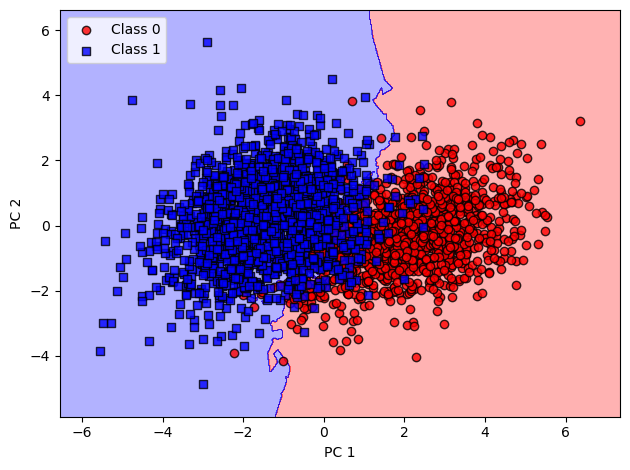

In [137]:
knn = KNeighborsClassifier(n_neighbors=5, p=2,
                            metric='minkowski')
knn.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train,
                      classifier=knn)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

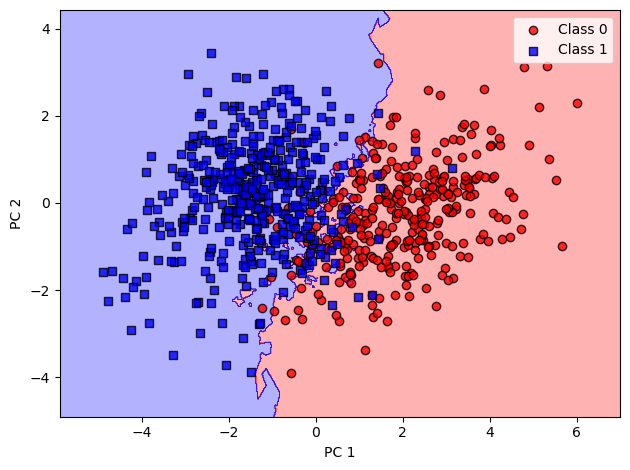

In [138]:
plot_decision_regions(X_test_pca, y_test, classifier=knn)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analysis of performance evaluation indicators for the KNN model

#### Combining transformers and estimators in a pipeline

In [139]:
pipe_knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(n_neighbors=5, 
                                             p=2,
                                             metric='minkowski'))
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
test_acc_knn = pipe_knn.score(X_test, y_test)
print(f'Test accuracy: {test_acc_knn: .3f}')

Test accuracy:  0.919


#### Confusion matrix

In [140]:
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[297  29]
 [ 33 403]]


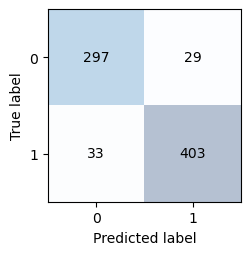

In [141]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [142]:
scores_knn = cross_val_score(estimator = pipe_knn,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_knn}')
print(f'CV accuracy scores: {np.mean(scores_knn):.3f}'
      f' +/- {np.std(scores_knn):.3f}')

CV accuracy scores: [0.92459016 0.90491803 0.90819672 0.94098361 0.91803279 0.94098361
 0.92786885 0.90491803 0.92434211 0.90789474]
CV accuracy scores: 0.920 +/- 0.013


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

In [143]:
pre_val_knn = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_knn}')

rec_val_knn = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_knn}')

f1_val_knn = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_knn}')

mcc_val_knn = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_knn:.3f}')

Precision: 0.9328703703703703
Recall: 0.9243119266055045
F1: 0.9285714285714285
MCC: 0.834


#### ROC curve

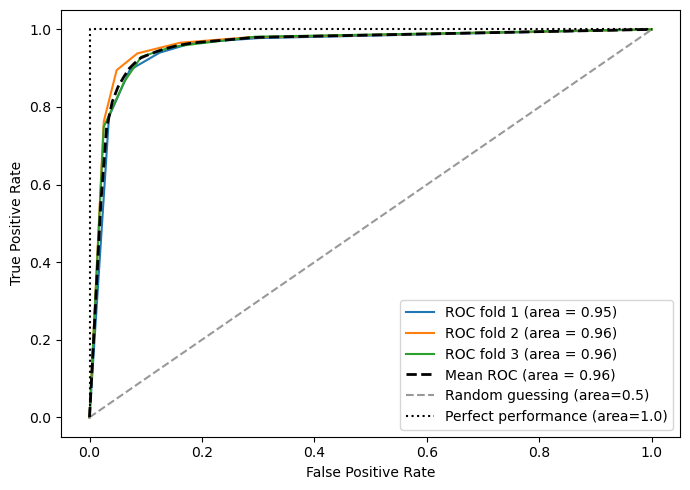

In [144]:
# Creating a pipeline using KNeighborsClassifier and StandardScaler
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, 
                                                               p=2,
                                                               metric='minkowski'))

# Data split for cross-validation
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Initializing the plot
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# For each cross-validation split
for i, (train, test) in enumerate(cv):
    # Fitting the model to the training data
    probas = pipe_knn.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Calculating True Positive Rate (TPR) and False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolating the results onto a mean ROC curve
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Calculating the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Displaying the ROC curve for each split
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Calculating the mean True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Calculating the mean area under the ROC curve (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Displaying the mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Displaying reference lines
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Setting axis and legend
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### Diagnosing bias and variance problems using learning curves

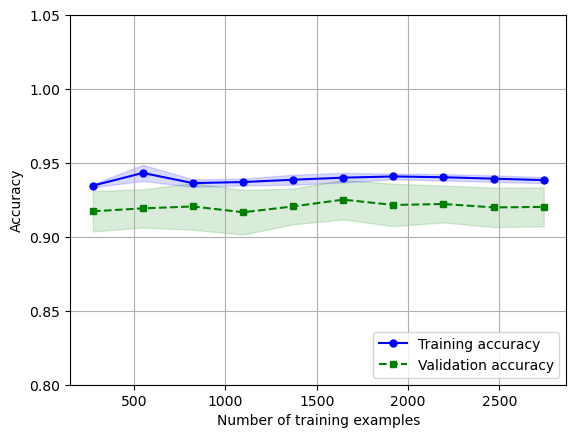

In [145]:
# Generating the learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_knn,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

# Calculating the means and standard deviations of accuracy for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.show()


### Dealing with the problem of over- and under-fitting using validation curves

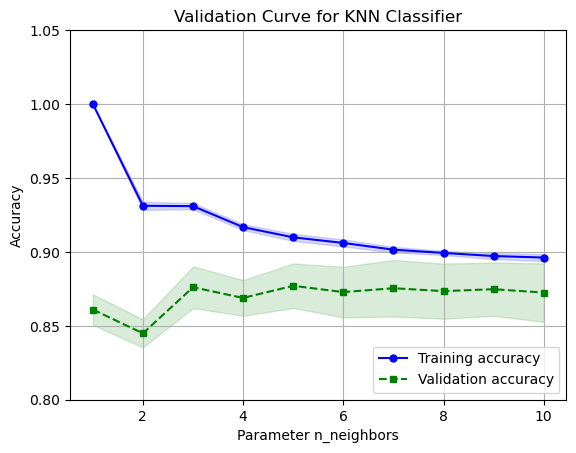

In [146]:
# Creating a KNeighborsClassifier instance
pipe_knn = KNeighborsClassifier()

# Define the parameter range for n_neighbors to be tested
param_range = range(1, 11)

# Generate the validation curve for the n_neighbors parameter in KNeighborsClassifier
train_scores, test_scores = validation_curve(estimator=pipe_knn,
                                             X=X_train,
                                             y=y_train,
                                             param_name='n_neighbors',
                                             param_range=param_range,
                                             cv=10)

# Calculate the mean accuracies for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Parameter n_neighbors')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.05])
plt.title('Validation Curve for KNN Classifier')
plt.show()

#### Tuning machine learning models through Grid Search

In [147]:
# Creating a pipeline containing StandardScaler and KNeighborsClassifier
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Definition of parameter grid to search
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],  # Example values for the n_neighbors parameter
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski'],  # Example values for the metric parameter
}

# Creating a GridSearchCV object
gs_knn = GridSearchCV(estimator=pipe_knn,
                  param_grid=param_grid,
                  scoring='accuracy',  # Choice of evaluation metric
                  cv=5,  # Number of cross-validation splits
                  n_jobs=-1)  # Utilize all CPU cores

# Running the grid search process
gs_knn.fit(X_train, y_train)

# Displaying the best parameters and results
print(gs_knn.best_score_)
print(gs_knn.best_params_)


0.9258494172117688
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 11}


In [148]:
clf_knn = gs_knn.best_estimator_
clf_knn.fit(X_train, y_train)
print(f'Test accuracy: {clf_knn.score(X_test, y_test):.3f}')

Test accuracy: 0.920


In [149]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_knn,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9160892994611238
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 11}


#### Nested cross-validation using GridSearchCV

In [150]:
nested_gs_knn = GridSearchCV(estimator = pipe_knn,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_knn = cross_val_score(nested_gs_knn, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_knn):.3f}'
      f' +/- {np.std(nested_scores_knn):.3f}')

CV accuracy: 0.924 +/- 0.007


#### Examination of hyperparameter configurations using Randomized Search

In [151]:
# Definition of parameter space to search
param_dist = {
    'kneighborsclassifier__n_neighbors': randint(1, 20),  # Example values for the n_neighbors parameter
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski'],  # Example values for the metric parameter
}

# Initializing RandomizedSearchCV
rs_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=20,
    n_jobs=-1,
    random_state=42
)

# Fitting the model
rs_knn.fit(X_train, y_train)

# Displaying the best score and best parameters
print(rs_knn.best_score_)
print(rs_knn.best_params_)


0.9258494172117688
{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 11}


## Random forests

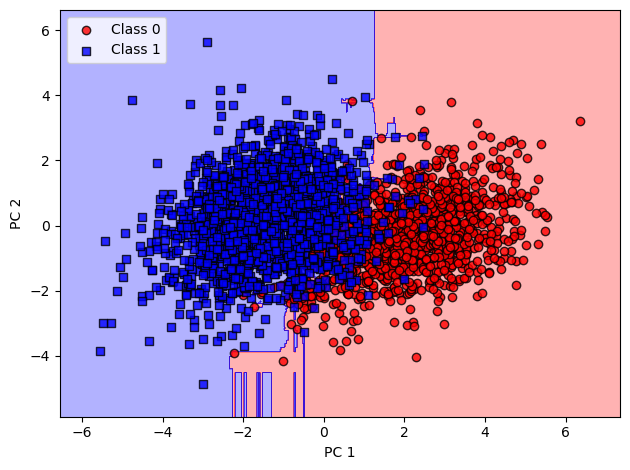

In [152]:
# Initializing the random forest
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train_pca, y_train)

# Generating visualization of decision boundaries
plot_decision_regions(X_train_pca, y_train, classifier=forest)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


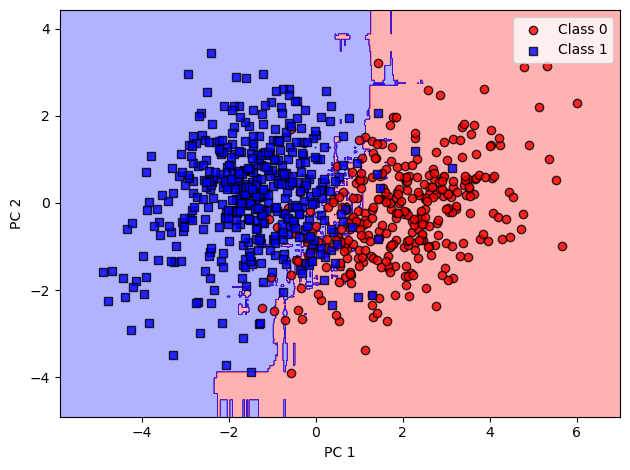

In [153]:
plot_decision_regions(X_test_pca, y_test, classifier=forest)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analysis of performance assessment indicators for the random forest model

#### Combining transformers and estimators in a pipeline

In [154]:
pipe_forest = make_pipeline(StandardScaler(),
                        RandomForestClassifier(n_estimators=100,
                                                random_state=1))
pipe_forest.fit(X_train, y_train)
y_pred = pipe_forest.predict(X_test)
test_acc_forest = pipe_forest.score(X_test, y_test)
print(f'Test accuracy: {test_acc_forest: .3f}')

Test accuracy:  0.925


#### Confusion matrix

In [155]:
pipe_forest.fit(X_train, y_train)
y_pred = pipe_forest.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[298  28]
 [ 29 407]]


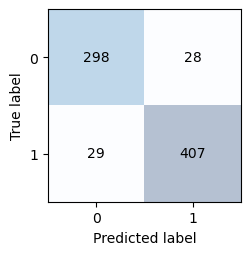

In [156]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [157]:
scores_forest = cross_val_score(estimator = pipe_forest,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_forest}')
print(f'CV accuracy scores: {np.mean(scores_forest):.3f}'
      f' +/- {np.std(scores_forest):.3f}')

CV accuracy scores: [0.93114754 0.92786885 0.90491803 0.92459016 0.92459016 0.95409836
 0.90163934 0.91803279 0.91447368 0.90789474]
CV accuracy scores: 0.921 +/- 0.015


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

In [158]:
pre_val_forest = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_forest}')

rec_val_forest = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_forest}')

f1_val_forest = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_forest}')

mcc_val_forest = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_forest:.3f}')

Precision: 0.9356321839080459
Recall: 0.9334862385321101
F1: 0.9345579793340987
MCC: 0.847


#### ROC curve

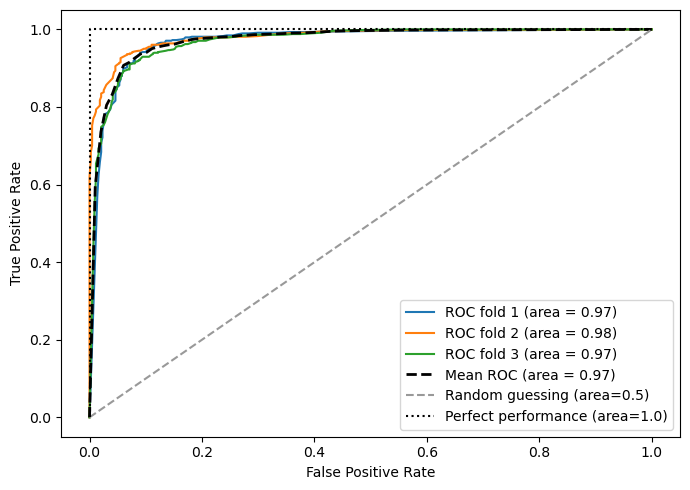

In [159]:
# Splitting the data for cross-validation
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Initializing the plot
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# For each cross-validation split
for i, (train, test) in enumerate(cv):
    # Fitting the model to the training data
    probas = pipe_forest.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Calculating the True Positive Rate (TPR) and False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolating the results onto the mean ROC curve
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Calculating the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Displaying the ROC curve for each split
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Calculating the mean True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Calculating the mean area under the ROC curve (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Displaying the mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Displaying reference lines
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Setting axis and legend
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### Diagnosing bias and variance problems using learning curves

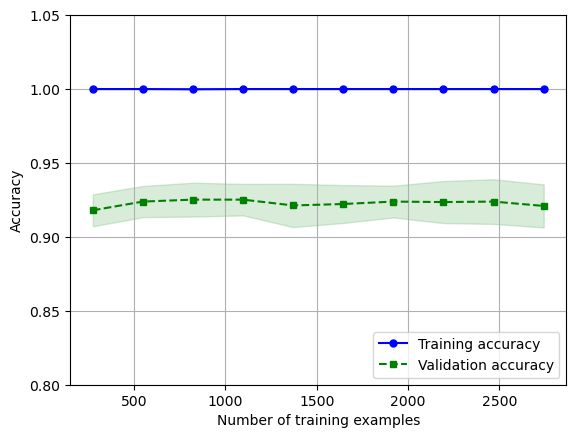

In [160]:
# Generating the learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_forest,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

# Calculating the mean and standard deviation of accuracies for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.show()


#### Dealing with the problem of over- and under-fitting using validation curves

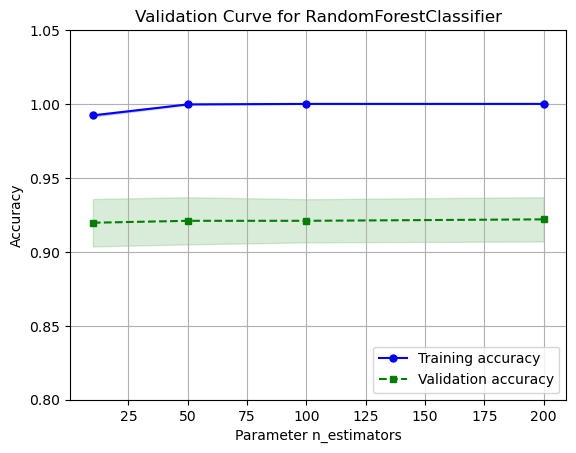

In [162]:
pipe_forest = RandomForestClassifier(random_state=1)

# Defining the range of the n_estimators parameter to be tested
param_range = [10, 50, 100, 200]

# Generating the validation curve for the n_estimators parameter in RandomForestClassifier
train_scores, test_scores = validation_curve(estimator=pipe_forest,
                                             X=X_train,
                                             y=y_train,
                                             param_name='n_estimators',
                                             param_range=param_range,
                                             cv=10)

# Calculating the mean accuracies for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Parameter n_estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.05])
plt.title('Validation Curve for RandomForestClassifier')
plt.show()


#### Tuning machine learning models through Grid Search

In [163]:
# Creating a pipeline containing StandardScaler and RandomForestClassifier
pipe_forest = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# Defining the parameter grid to search
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150],  # Number of estimators
    'randomforestclassifier__max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'randomforestclassifier__bootstrap': [True, False]  # Whether to use bootstrap when building trees
}

# Creating a GridSearchCV object
gs_forest = GridSearchCV(estimator=pipe_forest,
                  param_grid=param_grid,
                  scoring='accuracy',  # Choosing the evaluation metric
                  cv=5,  # Number of cross-validation splits
                  n_jobs=-1)  # Utilizing all CPU cores

# Running the grid search process
gs_forest.fit(X_train, y_train)

# Displaying the best parameters and results
print(gs_forest.best_score_)
print(gs_forest.best_params_)


0.927159815876605
{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50}


In [164]:
clf_forest = gs_forest.best_estimator_
clf_forest.fit(X_train, y_train)
print(f'Test accuracy: {clf_forest.score(X_test, y_test):.3f}')

Test accuracy: 0.928


In [165]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_forest,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9130744027489555
{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}


#### Nested cross-validation using GridSearchCV

In [166]:
nested_gs_forest = GridSearchCV(estimator = pipe_forest,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_forest = cross_val_score(nested_gs_forest, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_forest):.3f}'
      f' +/- {np.std(nested_scores_forest):.3f}')

CV accuracy: 0.924 +/- 0.010


#### Examination of hyperparameter configurations using Randomized Search

In [167]:
# Definition of the parameter space to search
param_dist = {
    'randomforestclassifier__n_estimators': randint(100, 1000),  # Number of estimators
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  # Maximum depth of the tree
    'randomforestclassifier__min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'randomforestclassifier__min_samples_leaf': randint(1, 20),  # Minimum number of samples required at a leaf node
    'randomforestclassifier__bootstrap': [True, False]  # Whether to use bootstrap when building trees
}

# Initialization of RandomizedSearchCV
rs_forest = RandomizedSearchCV(
    estimator=pipe_forest,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=20,
    n_jobs=-1,
    random_state=42
)

# Fitting the model
rs_forest.fit(X_train, y_train)

# Displaying the best score and best parameters
print(rs_forest.best_score_)
print(rs_forest.best_params_)

0.9284718296589409
{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__min_samples_split': 12, 'randomforestclassifier__n_estimators': 171}


## Neural networks

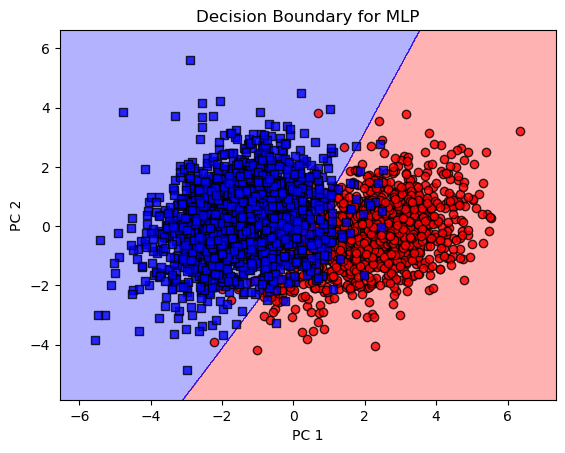

In [168]:
# Initialization of the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=1)

# Fitting the classifier to the data
mlp.fit(X_train_pca, y_train)

# Visualizing decision boundaries
plot_decision_regions(X_train_pca, y_train, classifier=mlp)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Decision Boundary for MLP')
plt.show()


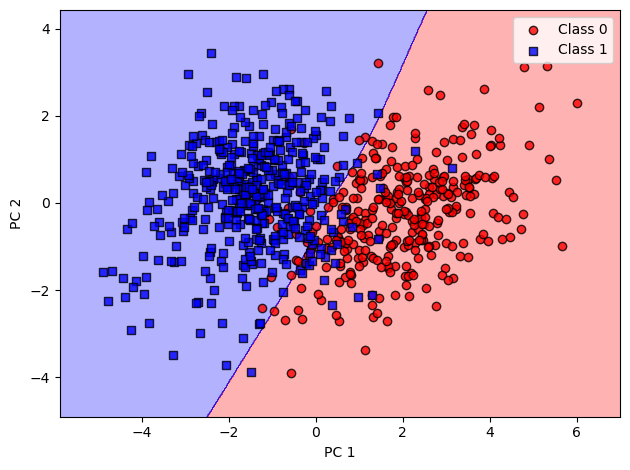

In [169]:
plot_decision_regions(X_test_pca, y_test, classifier=mlp)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analysis of performance evaluation indicators for the neurnon network model

#### Combining transformers and estimators in a pipeline

In [170]:
pipe_mlp = make_pipeline(StandardScaler(),
                        MLPClassifier(hidden_layer_sizes=(100, 100),
                                    max_iter=1000,
                                    random_state=1))
pipe_mlp.fit(X_train, y_train)
y_pred = pipe_mlp.predict(X_test)
test_acc_mlp = pipe_mlp.score(X_test, y_test)
print(f'Test accuracy: {test_acc_mlp: .3f}')

Test accuracy:  0.925


#### Confusion matrix

In [171]:
pipe_mlp.fit(X_train, y_train)
y_pred = pipe_mlp.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[300  26]
 [ 31 405]]


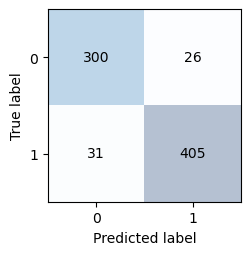

In [172]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [173]:
scores_mlp = cross_val_score(estimator = pipe_mlp,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_mlp}')
print(f'CV accuracy scores: {np.mean(scores_mlp):.3f}'
      f' +/- {np.std(scores_mlp):.3f}')

CV accuracy scores: [0.93770492 0.93114754 0.91803279 0.94754098 0.92459016 0.95737705
 0.92786885 0.90491803 0.91776316 0.91447368]
CV accuracy scores: 0.928 +/- 0.015


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

In [174]:
pre_val_mlp = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_mlp}')

rec_val_mlp = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_mlp}')

f1_val_mlp = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_mlp}')

mcc_val_mlp = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_mlp:.3f}')

Precision: 0.9396751740139211
Recall: 0.9288990825688074
F1: 0.9342560553633218
MCC: 0.848


#### ROC curve

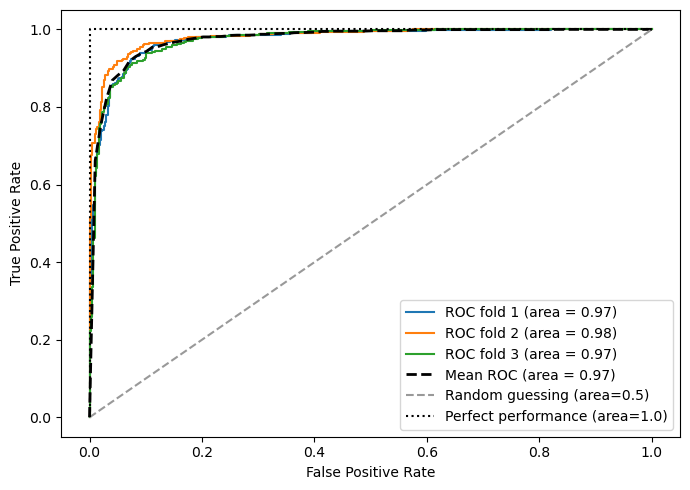

In [175]:
# Splitting the data for cross-validation
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Initializing the plot
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# For each cross-validation split
for i, (train, test) in enumerate(cv):
    # Fitting the model to the training data
    probas = pipe_mlp.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Calculating True Positive Rate (TPR) and False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolating results to get the mean ROC curve
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Calculating the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Displaying the ROC curve for each split
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Calculating the mean True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Calculating the mean area under the ROC curve (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Displaying the mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Displaying reference lines
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Setting axes and legend
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### Diagnosing bias and variance problems using learning curves

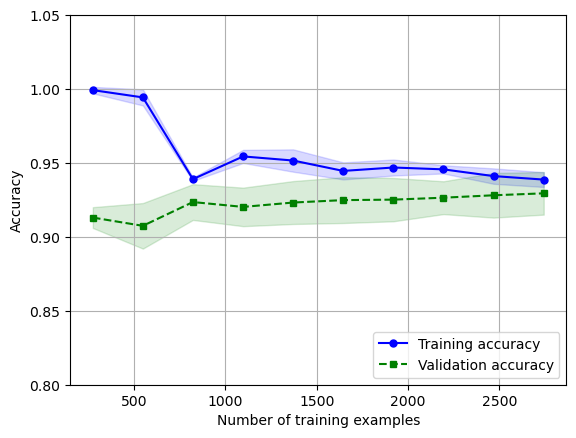

In [176]:
# Generating the learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_mlp,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

# Calculating the mean and standard deviation of accuracies for training and testing data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.show()


#### Dealing with over- and under-fitting using validation curves

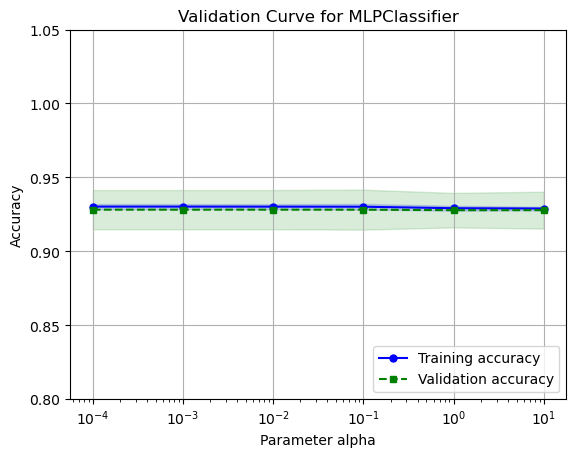

In [177]:
# Create a pipeline containing StandardScaler and MLPClassifier
pipe_mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=1000))

# Define the range of alpha parameter to test
param_range_alpha = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

# Generate the validation curve for the alpha parameter in MLPClassifier
train_scores, test_scores = validation_curve(estimator=pipe_mlp,
                                             X=X_train,
                                             y=y_train,
                                             param_name='mlpclassifier__alpha',
                                             param_range=param_range_alpha,
                                             cv=10)

# Calculate the mean accuracies for training and testing data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range_alpha, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range_alpha, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range_alpha, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range_alpha,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter alpha')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.05])
plt.title('Validation Curve for MLPClassifier')
plt.show()


#### Tuning machine learning models through Grid Search

In [178]:
# Definition of the parameter grid to search
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Example configurations of hidden layers
    'mlpclassifier__activation': ['logistic', 'relu'],  # Activation functions
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
}

# Create a GridSearchCV object
gs_mlp = GridSearchCV(estimator=pipe_mlp,
                  param_grid=param_grid,
                  scoring='accuracy',  # Choice of evaluation metric
                  cv=5,  # Number of cross-validation splits
                  n_jobs=-1)  # Utilize all CPU cores

# Run the grid search process
gs_mlp.fit(X_train, y_train)

# Display the best score and parameters
print(gs_mlp.best_score_)
print(gs_mlp.best_params_)


0.9294575897063178
{'mlpclassifier__activation': 'logistic', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (100, 100)}


In [179]:
clf_mlp = gs_mlp.best_estimator_
clf_mlp.fit(X_train, y_train)
print(f'Test accuracy: {clf_mlp.score(X_test, y_test):.3f}')

Test accuracy: 0.920


In [180]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_mlp,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9172959662288931
{'mlpclassifier__activation': 'logistic', 'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (100, 100)}


#### Nested cross-validation using GridSearchCV

In [181]:
nested_gs_mlp = GridSearchCV(estimator = pipe_mlp,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_mlp = cross_val_score(nested_gs_mlp, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_mlp):.3f}'
      f' +/- {np.std(nested_scores_mlp):.3f}')

CV accuracy: 0.928 +/- 0.012


#### Examination of hyperparameter configurations using Randomized Search

In [182]:
# Create a pipeline with MLPClassifier
pipe_mlp = MLPClassifier()

# Define the parameter space to search
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Example configurations of hidden layers
    'activation': ['logistic', 'relu'],  # Activation functions
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
}

# Initialize RandomizedSearchCV
rs_mlp = RandomizedSearchCV(
    estimator=pipe_mlp,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=20,
    n_jobs=-1,
    random_state=42
)

# Fit the model
rs_mlp.fit(X_train, y_train)

# Display the best score and best parameters
print(rs_mlp.best_score_)
print(rs_mlp.best_params_)


0.678503324450187
{'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}


## LDA

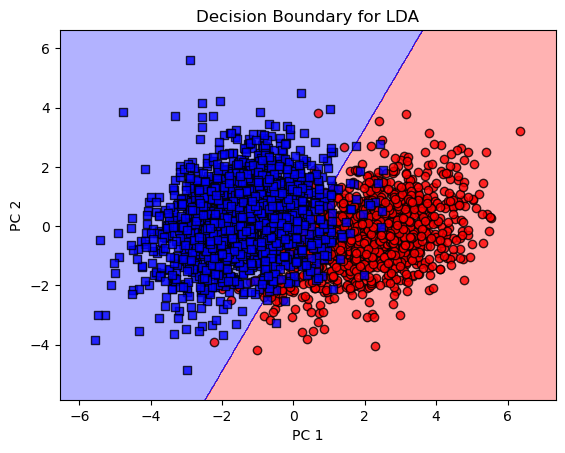

In [183]:
# Initialization of the LDA classifier
lda = LDA()

# Fitting the classifier to the data
lda.fit(X_train_pca, y_train)

# Visualization of decision boundaries
plot_decision_regions(X_train_pca, y_train, classifier=lda)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Decision Boundary for LDA')
plt.show()


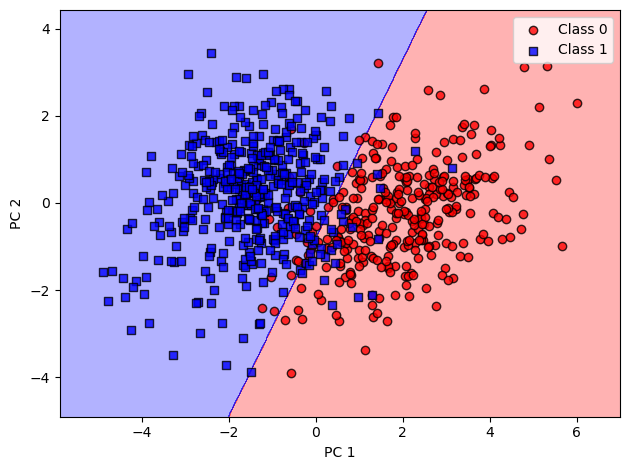

In [184]:
plot_decision_regions(X_test_pca, y_test, classifier=lda)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analysis of performance evaluation indicators for the LDA model

#### Combining transformers and estimators in a pipeline

In [185]:
pipe_lda = make_pipeline(StandardScaler(),
                        LDA())
pipe_lda.fit(X_train, y_train)
y_pred = pipe_lda.predict(X_test)
test_acc_lda = pipe_lda.score(X_test, y_test)
print(f'Test accuracy: {test_acc_lda: .3f}')

Test accuracy:  0.923


#### Confusion matrix

In [186]:
pipe_lda.fit(X_train, y_train)
y_pred = pipe_lda.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[291  35]
 [ 24 412]]


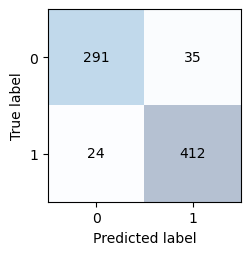

In [187]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [188]:
scores_lda = cross_val_score(estimator = pipe_lda,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_lda}')
print(f'CV accuracy scores: {np.mean(scores_lda):.3f}'
      f' +/- {np.std(scores_lda):.3f}')

CV accuracy scores: [0.93770492 0.9442623  0.92459016 0.93442623 0.92786885 0.95737705
 0.92786885 0.91147541 0.92763158 0.92434211]
CV accuracy scores: 0.932 +/- 0.012


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

In [189]:
pre_val_lda = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_lda}')

rec_val_lda = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_lda}')

f1_val_lda = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_lda}')

mcc_val_lda = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_lda:.3f}')

Precision: 0.9217002237136466
Recall: 0.944954128440367
F1: 0.9331823329558324
MCC: 0.842


#### ROC curve

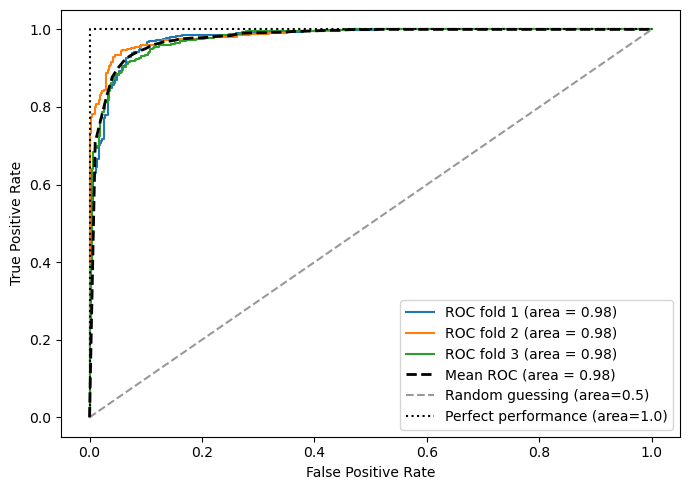

In [190]:
# Data split for cross-validation
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Initialization of the plot
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# For each cross-validation split
for i, (train, test) in enumerate(cv):
    # Fitting the model to the training data
    probas = pipe_lda.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Computing True Positive Rate (TPR) and False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolating the results onto the mean ROC curve
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Computing the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Displaying the ROC curve for each split
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Computing the mean True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Computing the mean area under the ROC curve (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Displaying the mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Displaying reference lines
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Setting axis and legend
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### Diagnosing bias and variance problems using learning curves

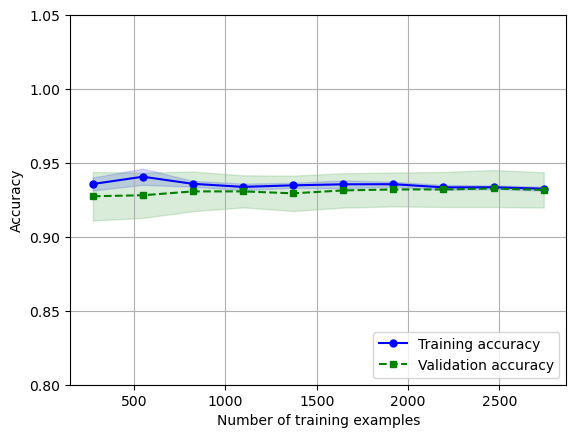

In [191]:
# Generating the learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lda,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

# Computing the mean and standard deviation of accuracy for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.show()


#### Dealing with over- and under-fitting using validation curves

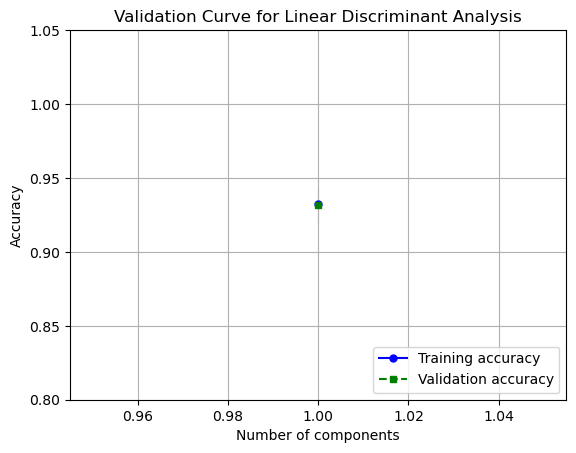

In [192]:
# Define the range of the parameter to test (e.g., number of components)
param_range = [1, 2, 3, 4, 5]  # You can adjust the parameter range according to your needs

# Generate the validation curve for the parameter in the LDA model
train_scores, test_scores = validation_curve(estimator=lda,
                                             X=X_train,
                                             y=y_train,
                                             param_name='n_components',  # Parameter to test
                                             param_range=param_range,
                                             cv=10)  # Number of cross-validation splits

# Calculate the mean accuracy for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.05])
plt.title('Validation Curve for Linear Discriminant Analysis')
plt.show()


#### Tuning machine learning models through Grid Search

In [193]:
# Define the parameter grid for grid search
param_grid = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr', 'eigen'],  # Choice of optimization algorithm
    'lineardiscriminantanalysis__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],  # Shrinkage parameter
    'lineardiscriminantanalysis__n_components': [None, 1, 2, 3]  # You can adjust these parameters
}

# Create a GridSearchCV object
gs_lda = GridSearchCV(estimator=pipe_lda,
                  param_grid=param_grid,
                  scoring='accuracy',  # Choice of evaluation metric
                  cv=5,  # Number of cross-validation splits
                  n_jobs=-1)  # Utilize all CPU cores

# Run the grid search process
gs_lda.fit(X_train, y_train)

# Display the best parameters and results
print(gs_lda.best_score_)
print(gs_lda.best_params_)


0.9310969339686128
{'lineardiscriminantanalysis__n_components': None, 'lineardiscriminantanalysis__shrinkage': None, 'lineardiscriminantanalysis__solver': 'svd'}


c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
190 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.f

In [194]:
clf_lda = gs_lda.best_estimator_
clf_lda.fit(X_train, y_train)
print(f'Test accuracy: {clf_lda.score(X_test, y_test):.3f}')

Test accuracy: 0.923


In [195]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_lda,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9187273399926008
{'lineardiscriminantanalysis__n_components': None, 'lineardiscriminantanalysis__shrinkage': None, 'lineardiscriminantanalysis__solver': 'svd'}


c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
76 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fi

#### Nested cross-validation using GridSearchCV

In [196]:
nested_gs_lda = GridSearchCV(estimator = pipe_lda,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_lda = cross_val_score(nested_gs_lda, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_lda):.3f}'
      f' +/- {np.std(nested_scores_lda):.3f}')

c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
76 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fi

CV accuracy: 0.931 +/- 0.009


c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
76 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fi

#### Examination of hyperparameter configurations using Randomized Search

In [197]:
# Create a pipeline for LDA
pipe_lda = Pipeline([
    ('scaler', StandardScaler()),  # If data normalization is needed
    ('lda', LDA())
])

# Define the parameter space to search
param_dist = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],  # Choice of optimization algorithm
    'lda__shrinkage': [None, 'auto'],  # Shrinkage parameter
    'lda__n_components': [None, 1, 2, 3]  # Number of components to consider
}

# Initialize RandomizedSearchCV
rs_lda = RandomizedSearchCV(
    estimator=pipe_lda,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=10,
    n_jobs=-1,
    random_state=42
)

# Fit the model
rs_lda.fit(X_train, y_train)

# Display the best score and best parameters
print(rs_lda.best_score_)
print(rs_lda.best_params_)


0.9310969339686128
{'lda__solver': 'eigen', 'lda__shrinkage': None, 'lda__n_components': 1}


c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit

## QDA

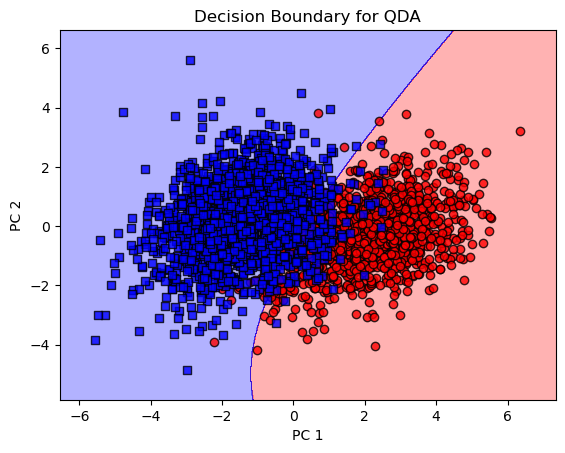

In [198]:
# Initialize the QDA classifier
qda = QDA()

# Fit the classifier to the data
qda.fit(X_train_pca, y_train)

# Visualize decision boundaries
plot_decision_regions(X_train_pca, y_train, classifier=qda)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Decision Boundary for QDA')
plt.show()


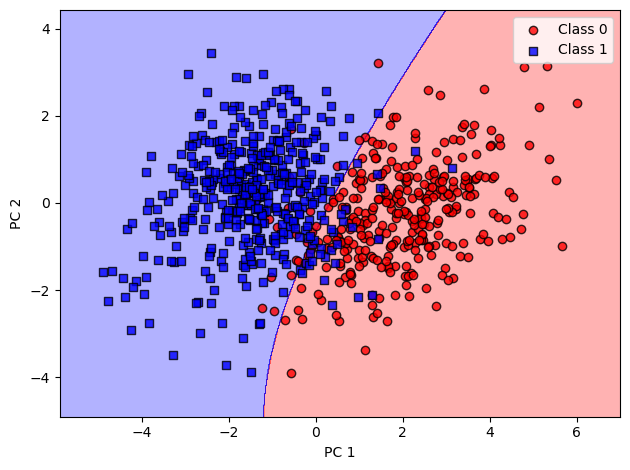

In [199]:
plot_decision_regions(X_test_pca, y_test, classifier=qda)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analysis of performance evaluation indicators for the QDA model

#### Combining transformers and estimators in a pipeline

In [200]:
pipe_qda = make_pipeline(StandardScaler(),
                        QDA())
pipe_qda.fit(X_train, y_train)
y_pred = pipe_qda.predict(X_test)
test_acc_qda = pipe_qda.score(X_test, y_test)
print(f'Test accuracy: {test_acc_qda: .3f}')

Test accuracy:  0.913


#### Confusion matrix

In [201]:
pipe_qda.fit(X_train, y_train)
y_pred = pipe_qda.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[303  23]
 [ 43 393]]


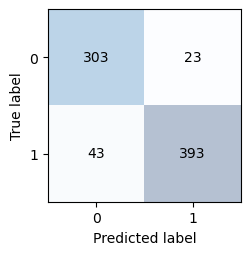

In [202]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Cross-validation

In [203]:
scores_qda = cross_val_score(estimator = pipe_qda,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores_qda}')
print(f'CV accuracy scores: {np.mean(scores_qda):.3f}'
      f' +/- {np.std(scores_qda):.3f}')

CV accuracy scores: [0.92459016 0.93114754 0.90819672 0.92786885 0.92786885 0.95081967
 0.94098361 0.92459016 0.91447368 0.92763158]
CV accuracy scores: 0.928 +/- 0.011


#### Optimizing precision, recall score, F1 score, and mathhews factor for classification model

In [204]:
pre_val_qda = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val_qda}')

rec_val_qda = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val_qda}')

f1_val_qda = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val_qda}')

mcc_val_qda = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val_qda:.3f}')

Precision: 0.9447115384615384
Recall: 0.9013761467889908
F1: 0.9225352112676056
MCC: 0.826


#### ROC curve

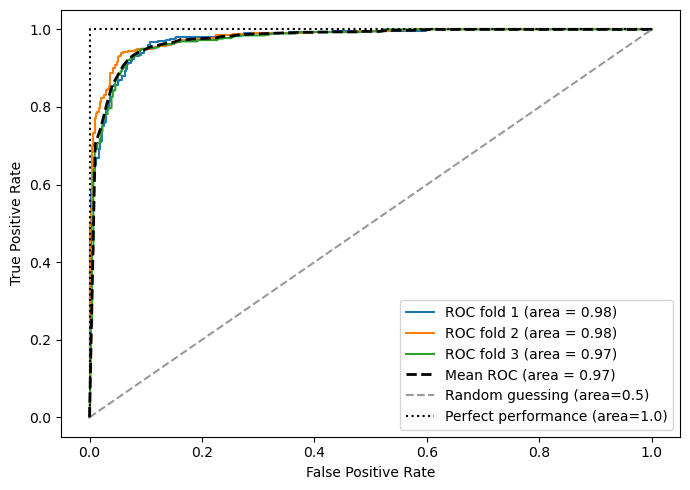

In [205]:
# Split the data for cross-validation
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# Initialize the plot
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# For each cross-validation split
for i, (train, test) in enumerate(cv):
    # Fit the model to the training data
    probas = pipe_qda.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # Interpolate the results onto the mean ROC curve
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    all_tpr.append(mean_tpr)
    
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for each split
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# Calculate the mean True Positive Rate
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean area under the ROC curve (AUC)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# Plot reference lines
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')

# Set axis and legend
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### Diagnosing bias and variance problems using learning curves

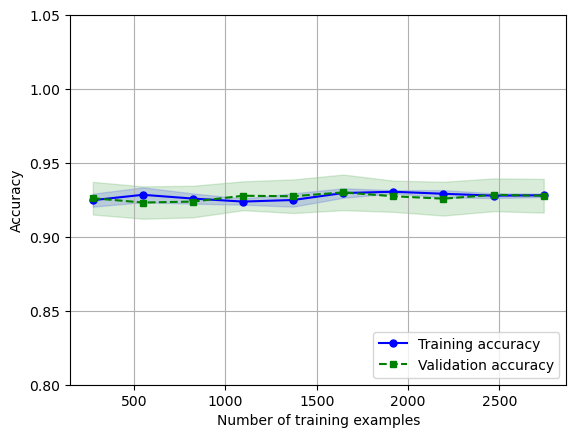

In [206]:
# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_qda,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

# Calculate the mean and standard deviation of accuracy for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.show()


#### Dealing with over- and under-fitting using validation curves

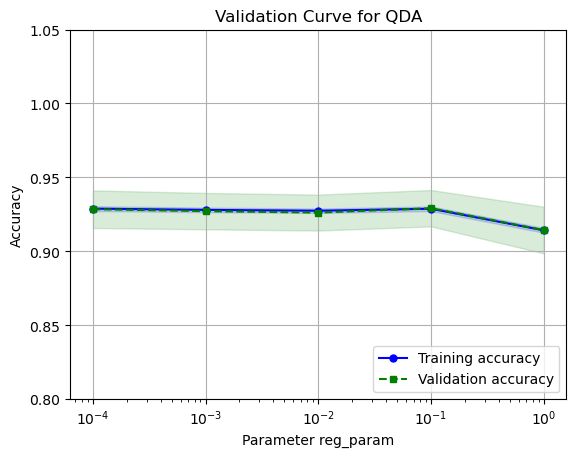

In [207]:
# Define the range of the reg_param parameter to test
param_range_reg_param = [0.0001, 0.001, 0.01, 0.1, 1.0]

# Generate the validation curve for the reg_param parameter in QDA
train_scores, test_scores = validation_curve(estimator=pipe_qda,
                                             X=X_train,
                                             y=y_train,
                                             param_name='quadraticdiscriminantanalysis__reg_param',
                                             param_range=param_range_reg_param,
                                             cv=10)

# Calculate the mean accuracy for training and test data
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range_reg_param, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range_reg_param, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range_reg_param, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range_reg_param,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter reg_param')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.05])
plt.title('Validation Curve for QDA')
plt.show()


#### Tuning machine learning models through Grid Search

In [208]:
# Create a pipeline containing StandardScaler and QDA
pipe_qda = make_pipeline(StandardScaler(), QDA())

# Define the parameter grid to search
param_grid = {
    'quadraticdiscriminantanalysis__reg_param': [0.1, 0.5, 1.0]  # Example values for the reg_param parameter
}

# Create a GridSearchCV object
gs_qda = GridSearchCV(estimator=pipe_qda,
                  param_grid=param_grid,
                  scoring='accuracy',  # Choose the evaluation metric
                  cv=5,  # Number of cross-validation splits
                  n_jobs=-1)  # Utilize all CPU cores

# Run the grid search process
gs_qda.fit(X_train, y_train)

# Display the best score and parameters
print(gs_qda.best_score_)
print(gs_qda.best_params_)


0.9288007752563999
{'quadraticdiscriminantanalysis__reg_param': 0.1}


In [209]:
clf_qda = gs_qda.best_estimator_
clf_qda.fit(X_train, y_train)
print(f'Test accuracy: {clf_qda.score(X_test, y_test):.3f}')

Test accuracy: 0.925


In [210]:
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_qda,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9157727180786042
{'quadraticdiscriminantanalysis__reg_param': 0.1}


#### Nested cross-validation using GridSearchCV

In [211]:
nested_gs_qda = GridSearchCV(estimator = pipe_qda,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
nested_scores_qda = cross_val_score(nested_gs_qda, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(nested_scores_qda):.3f}'
      f' +/- {np.std(nested_scores_qda):.3f}')

CV accuracy: 0.929 +/- 0.010


#### Examination of hyperparameter configurations using Randomized Search

In [212]:
# Create a pipeline for QDA
pipe_qda = Pipeline([
    ('scaler', StandardScaler()),  # If data normalization is needed
    ('qda', QDA())
])

# Define the parameter space to search
param_dist = {
    'qda__reg_param': [0.1, 0.5, 1.0]  # QDA regularization parameter
    # Additional QDA parameters can also be included here
}

# Initialize RandomizedSearchCV
rs_qda = RandomizedSearchCV(
    estimator=pipe_qda,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=10,
    n_jobs=-1,
    random_state=42
)

# Fit the model
rs_qda.fit(X_train, y_train)

# Display the best score and best parameters
print(rs_qda.best_score_)
print(rs_qda.best_params_)


0.9288007752563999
{'qda__reg_param': 0.1}


c:\Users\dawid\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Summary

In [213]:
klasyfikatory = [
    "Logistic regression",
    "SVM",
    "Decision TRee",
    "KNN",
    "Random forests",
    "Neural networks",
    "LDA",
    "QDA"
]

dokladnosci = [test_acc_lr, test_acc_svc, test_acc_dt, test_acc_knn, test_acc_forest, test_acc_mlp, test_acc_lda, test_acc_qda]
dokladnosci_CV = [np.mean(scores_lr), np.mean(scores_svc), np.mean(scores_dt), np.mean(scores_knn),
                np.mean(scores_forest), np.mean(scores_mlp), np.mean(scores_lda), np.mean(scores_qda)]
dokladnosci_2 = [pre_val_lr, pre_val_svc, pre_val_dt, pre_val_knn, pre_val_forest, pre_val_mlp, pre_val_lda, pre_val_qda]
recall = [rec_val_lr, rec_val_svc, rec_val_dt, rec_val_knn, rec_val_forest, rec_val_mlp, rec_val_lda, rec_val_qda]
f1 = [f1_val_lr, f1_val_svc, f1_val_dt, f1_val_knn, f1_val_forest, f1_val_mlp, f1_val_lda, f1_val_qda]
mcc = [mcc_val_lr, mcc_val_svc, mcc_val_dt, mcc_val_knn, mcc_val_forest, mcc_val_mlp, mcc_val_lda, mcc_val_qda]

grid_search = [gs_lr.best_score_, gs_svc.best_score_, gs_dt.best_score_, gs_knn.best_score_,
                gs_forest.best_score_, gs_mlp.best_score_, gs_lda.best_score_, gs_qda.best_score_]

nested_grid_seach = [np.mean(nested_scores_lr), np.mean(nested_scores_lr), np.mean(nested_scores_dt), np.mean(nested_scores_knn),
                    np.mean(nested_scores_forest), np.mean(nested_scores_mlp), np.mean(nested_scores_lda), np.mean(nested_scores_qda)]


random_search = [rs_lr.best_score_, rs_svc.best_score_, rs_dt.best_score_, rs_knn.best_score_,
                rs_forest.best_score_, rs_mlp.best_score_, rs_lda.best_score_, rs_qda.best_score_]

# Convert 'klasyfikatory' to a DataFrame
classifier_df = pd.DataFrame({"Klasyfikator": klasyfikatory})

# Create the summary DataFrame
df = pd.DataFrame({
    "Accuracy": dokladnosci,
    "Accuracy CV": dokladnosci_CV,
    "Optimised accuracy": dokladnosci_2,
    "Recall": recall,
    "F1 score": f1,
    "MCC": mcc,
    "Grid Search": grid_search,
    "Nested Grid Search": nested_grid_seach,
    "Random Search": random_search
})

# Concatenate the 'classifier_df' and 'df' DataFrames along the columns axis
summary = pd.concat([classifier_df, df], axis=1)
summary


,Klasyfikator,Accuracy,Accuracy CV,Optimised accuracy,Recall,F1 score,MCC,Grid Search,Nested Grid Search,Random Search
0,Logistic regression,0.922572,0.923227,0.939394,0.924312,0.931792,0.842423,0.931428,0.929783,0.931428
1,SVM,0.919948,0.931424,0.933025,0.926606,0.929804,0.836704,0.931424,0.929783,0.931424
2,Decision TRee,0.888451,0.888764,0.911007,0.892202,0.901506,0.773169,0.924537,0.924537,0.925523
3,KNN,0.918635,0.920273,0.932870,0.924312,0.928571,0.834112,0.925849,0.923880,0.925849
4,Random forests,0.925197,0.920925,0.935632,0.933486,0.934558,0.847272,0.927160,0.923550,0.928472
5,Neural networks,0.925197,0.928142,0.939675,0.928899,0.934256,0.847581,0.929458,0.928143,0.678503
6,LDA,0.922572,0.931755,0.921700,0.944954,0.933182,0.841542,0.931097,0.931097,0.931097
7,QDA,0.913386,0.927817,0.944712,0.901376,0.922535,0.825613,0.928801,0.928801,0.928801


### Best parameters for classifier data

In [214]:
best_estimator_gs = [gs_lr.best_params_, gs_svc.best_params_, gs_dt.best_params_, gs_knn.best_params_,
                gs_forest.best_params_, gs_mlp.best_params_, gs_lda.best_params_, gs_qda.best_params_]

best_estimator_rs = [rs_lr.best_params_, rs_svc.best_params_, rs_dt.best_params_, rs_knn.best_params_,
                rs_forest.best_params_, rs_mlp.best_params_, rs_lda.best_params_, rs_qda.best_params_]

lista = []
parametry = []

for klasyfikator, estim in zip(klasyfikatory, best_estimator_gs):
    for key in estim:
        lista.append(klasyfikator)
        parametry.append(key)

index = [np.array(lista), np.array(parametry)]
results_01 = pd.DataFrame(np.zeros((len(index[0]), 1)), index=index, columns=["Grid Search CV"])


for klasyfikator, dict in zip(klasyfikatory, best_estimator_gs):
    for param, value in dict.items():
        results_01.loc[(klasyfikator, param), "Grid Search CV"] = value


In [215]:
results_01

Grid Search CV
Logistic regression logisticregression__C                               10.0
                    logisticregression__solver                           sag
SVM                 svc__C                                              10.0
                    svc__kernel                                       linear
Decision TRee       decisiontreeclassifier__criterion                   gini
                    decisiontreeclassifier__max_depth                      1
                    decisiontreeclassifier__min_samples_leaf               1
                    decisiontreeclassifier__min_samples_split              2
KNN                 kneighborsclassifier__metric                   euclidean
                    kneighborsclassifier__n_neighbors                     11
Random forests      randomforestclassifier__bootstrap                  False
                    randomforestclassifier__max_depth                      5
                    randomforestclassifier__n_estimators                  50
Neural networks     mlpclassifier__activation                       logistic
                    mlpclassifier__alpha                                0.01
                    mlpclassifier__hidden_layer_sizes             (100, 100)
LDA                 lineardiscriminantanalysis__n_components            None
                    lineardiscriminantanalysis__shrinkage               None
                    lineardiscriminantanalysis__solver                   svd
QDA                 quadraticdiscriminantanalysis__reg_param             0.1

In [216]:
lista = []
parametry = []
for klasyfikator, estim in zip(klasyfikatory, best_estimator_rs):
    for key in estim:
        lista.append(klasyfikator)
        parametry.append(key)

index = [np.array(lista), np.array(parametry)]
results_02 = pd.DataFrame(np.zeros((len(index[0]), 1)), index=index, columns=["Randomized Search CV"])

for klasyfikator, dict in zip(klasyfikatory, best_estimator_rs):
    for param, value in dict.items():
        results_02.loc[(klasyfikator, param), "Randomized Search CV"] = value

In [217]:
results_02

Randomized Search CV
Logistic regression logisticregression__solver                                 sag
                    logisticregression__C                                     10.0
SVM                 svc__kernel                                             linear
                    svc__C                                                    10.0
Decision TRee       decisiontreeclassifier__criterion                      entropy
                    decisiontreeclassifier__max_depth                            4
                    decisiontreeclassifier__min_samples_leaf                    14
                    decisiontreeclassifier__min_samples_split                   32
KNN                 kneighborsclassifier__metric                         minkowski
                    kneighborsclassifier__n_neighbors                           11
Random forests      randomforestclassifier__bootstrap                         True
                    randomforestclassifier__max_depth                           30
                    randomforestclassifier__min_samples_leaf                    15
                    randomforestclassifier__min_samples_split                   12
                    randomforestclassifier__n_estimators                       171
Neural networks     hidden_layer_sizes                                      (100,)
                    alpha                                                   0.0001
                    activation                                                relu
LDA                 lda__solver                                              eigen
                    lda__shrinkage                                            None
                    lda__n_components                                            1
QDA                 qda__reg_param                                             0.1

# Conclusion
We can see that all the results give very high scores, which shows us that the classification has been done successfully. Classifiers such as LDA, logistic regression, random forests and neural networks gave the highest results. The observations classified $Cammeo$ and $Osmancik$ were correctly classified in a very high percentage of cases.